# 01NAEX - Protocol: Optimalizácia hyperparametrov algoritmu XGBoost

## XGboost hyperparameter search

<a target="_blank" href="https://colab.research.google.com/github/Many98/xgboost_hyper_search/blob/main/xgboost_hyper_search.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>



In [ ]:
cat(system('sudo apt-get install -y gmp', intern=TRUE), sep = "\n")
cat(system('sudo apt-get install -y partitions', intern=TRUE), sep = "\n")
cat(system('sudo apt-get install -y DoE.base', intern=TRUE), sep = "\n")

list_of_packages <- c("tidyverse", "car","nortest","lattice","pwr","MASS",
                      "agricolae", "FrF2", "rsm")
missing_packages <- list_of_packages[!(list_of_packages %in% installed.packages()[,"Package"])]

if(length(missing_packages)) install.packages(missing_packages)
lapply(list_of_packages, library, character.only = TRUE)

# Úvod

V tomto protokole je naším cieľom nájsť optimálne nastavenie hyperparametrov pre algoritmus XGBoost. Konkrétne sa snažíme predikovať cenu bytov v CZK na základe tabulárnych dát.
  Pripravený dataset obsahuje celkovo 8191 vzoriek pričom 85% (6962) dát bolo použitých na tréning
a zvyšných 15% (1229) na test predikčných vlastností modelu. Hodnotenou metrikou je mean absolute error (MAE) nad testovacím datasetom (v jednotkách CZK).

Dodatočnými hyperparametrami algoritmu boli okrem iných:

-  `objective='reg:squarederror'` t.j. L2 norma bola použitá        ako strátová funkcia
- `tree_method='hist'`  kvôli rýchlosti
- `booster='gbtree'`
- `random_state=42`

# Nastavenie experimentu

Na návrh experimentu používame 2^(8-2) dizajn.

Ak označíme faktory naslednovne pričom predpokladáme, že posledné dva nebudú mať významný vplyv na výslednú hodnotu MAE metriky:

*   colsample_bytree - A
*   colsample_bynode - B
*   max_depth	- C
*   learning_rate	- D
*   n_estimators - E
*   subsample - F
*   gamma	- G
*   max_leaves - H

Tak získame takúto štruktúru generátorov:
 - G = ABCD, H = ABEF

a definujúce vzťahy sú:

 - I = ABCDG = ABEFH.

  
Rozlišenie modelu (resolution) je teda typu V.

Dodatočne bolo vykonaných 5 replikovaných meraní v centrálnych bodoch a taktiež 16 nereplikovaných meraní v central composite bodoch kvôli zisteným kvadratickým závislostiam.


## Uvažované úrovne hyperparametrov

Nasledujúca tabuľka popisuje skúmané faktory, ich hodnoty a zobrazenie. Podotknime, že hodnoty faktorov na úrovni `-1` a `1`
definujú hranice oblasti záujmu v ktorej budú hyperparametre optimalizované.


|       |              **factor** |   **-1** |   **1** | **0 (centerpoint)**   |
|-------|------------------------:|--------:|--------:|-----------------:|
| **A** |           *colsample_bytree* |     0.5 |     1.0 |              0.75 |
| **B** |              *colsample_bynode* |     0.5 |     1.0 |              0.75 |
| **C** |                 *max_depth* |     3 |     15  |             9     |
| **D** |               *learning_rate* | 0.08999 | 0.15 |              0.119995    |
| **E** |*n_estimators* |     100 |     700 |              400 |
| **F** |            *subsample* |     0.5 |      1.0 |          0.75        |
| **G** |            *gamma* |     0.0 |      1.0 |         0.5         |
| **H** |            *max_leaves* |     0 |      100 |              50    |



# Dizajn pomocou FrF


In [ ]:
design =FrF2(2^(8-2), 8, replications = 1, randomize = TRUE, seed=42,
generators=c("ABCD","ABEF"),
factor.names = c("colsample_bytree", "colsample_bynode",
                 "max_depth", "learning_rate", "n_estimators", "subsample",
                 "gamma", "max_leaves")
                 )

# export for later measurement in python
# write.csv(design, "design.csv", row.names=FALSE)

summary(design)
head(design)

Call:
FrF2(2^(8 - 2), 8, replications = 1, randomize = TRUE, seed = 42, 
    generators = c("ABCD", "ABEF"), factor.names = c("colsample_bytree", 
        "colsample_bynode", "max_depth", "learning_rate", "n_estimators", 
        "subsample", "gamma", "max_leaves"))

Experimental design of type  FrF2.generators 
64  runs

Factor settings (scale ends):
  colsample_bytree colsample_bynode max_depth learning_rate n_estimators
1               -1               -1        -1            -1           -1
2                1                1         1             1            1
  subsample gamma max_leaves
1        -1    -1         -1
2         1     1          1

Design generating information:
$legend
[1] A=colsample_bytree B=colsample_bynode C=max_depth        D=learning_rate   
[5] E=n_estimators     F=subsample        G=gamma            H=max_leaves      

$generators
[1] G=ABCD H=ABEF


Alias structure:
[[1]]
[1] no aliasing among main effects and 2fis



,colsample_bytree,colsample_bynode,max_depth,learning_rate,n_estimators,subsample,gamma,max_leaves
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,-1,-1,-1,-1,1,1,1,1
2,-1,-1,1,-1,-1,1,-1,-1
3,-1,-1,-1,-1,-1,-1,1,1
4,-1,-1,-1,1,1,-1,-1,-1
5,1,-1,-1,1,-1,-1,1,-1
6,1,1,-1,-1,-1,1,1,-1


# Namerané dáta podľa (permutácie) vyššie uvedeného dizajnu

Permutácia bola potrebné pretože sme pozabudli nastaviť konkrétny seed
a preto musíme merania následne preusporiadať...

Data.Frame `measured_design` obsahuje všetky merania vrátane centrálnych a central composite meraní.

In [ ]:
measured_design <- read.table("https://raw.githubusercontent.com/Many98/xgboost_hyper_search/main/naex_design_measure_measure_composite.csv",header=TRUE,sep=",")

head(measured_design, 5)
tail(measured_design, 5)

,colsample_bytree,colsample_bynode,max_depth,learning_rate,n_estimators,subsample,gamma,max_leaves,test_mae,train_mae
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
1,-1,-1,1,-1,-1,1,-1,-1,164889.9,8864.859
2,1,-1,1,1,1,-1,-1,1,110614.2,2947.114
3,1,-1,-1,1,-1,-1,1,-1,225543.5,156722.187
4,-1,1,1,1,1,-1,-1,1,181386.2,5386.096
5,-1,-1,-1,-1,-1,-1,1,1,366604.9,322576.647


,colsample_bytree,colsample_bynode,max_depth,learning_rate,n_estimators,subsample,gamma,max_leaves,test_mae,train_mae
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
81,0,0,0,0,0,-1,0,0,111467.97,17028.729
82,0,0,0,0,0,0,1,0,86700.16,8438.525
83,0,0,0,0,0,0,-1,0,139068.32,24418.823
84,0,0,0,0,0,0,0,1,86168.21,8685.444
85,0,0,0,0,0,0,0,-1,129254.21,22787.819


# Skutočné hodnoty sledovaných hyperparametrov

In [ ]:
data <- read.table("https://raw.githubusercontent.com/Many98/xgboost_hyper_search/main/naex_design_measure_values.csv",header=TRUE,sep=",")
head(data)


,colsample_bytree,colsample_bynode,max_depth,learning_rate,n_estimators,subsample,gamma,max_leaves,test_mae,train_mae
,<dbl>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
1,0.5,0.5,15,0.08999,100,1.0,0,0,164889.9,8864.859
2,1.0,0.5,15,0.15000,700,0.5,0,100,110614.2,2947.114
3,1.0,0.5,3,0.15000,100,0.5,1,0,225543.5,156722.187
4,0.5,1.0,15,0.15000,700,0.5,0,100,181386.2,5386.096
5,0.5,0.5,3,0.08999,100,0.5,1,100,366604.9,322576.647
6,0.5,1.0,3,0.08999,700,1.0,0,0,121446.5,54506.775


# Korekcia FrF dizajn objektu aby sedel na naše merania

In [ ]:
design$colsample_bytree = measured_design[1:64, 'colsample_bytree']
design$colsample_bynode= measured_design[1:64, 'colsample_bynode']
design$max_depth = measured_design[1:64, 'max_depth']
design$learning_rate = measured_design[1:64, 'learning_rate']
design$n_estimators = measured_design[1:64, 'n_estimators']
design$subsample = measured_design[1:64, 'subsample']
design$gamma = measured_design[1:64, 'gamma']
design$max_leaves = measured_design[1:64, 'max_leaves']


# Adding response (testing mean absolute error) to the design
test_mae = measured_design[1:64, 'test_mae']
design = add.response(design, test_mae)

# now it corresponds to measured data
head(design)

,colsample_bytree,colsample_bynode,max_depth,learning_rate,n_estimators,subsample,gamma,max_leaves,test_mae
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
1,-1,-1,1,-1,-1,1,-1,-1,164889.9
2,1,-1,1,1,1,-1,-1,1,110614.2
3,1,-1,-1,1,-1,-1,1,-1,225543.5
4,-1,1,1,1,1,-1,-1,1,181386.2
5,-1,-1,-1,-1,-1,-1,1,1,366604.9
6,-1,1,-1,-1,1,1,-1,-1,121446.5


In [ ]:
summary(design)

Call:
FrF2(2^(8 - 2), 8, replications = 1, randomize = TRUE, seed = 42, 
    generators = c("ABCD", "ABEF"), factor.names = c("colsample_bytree", 
        "colsample_bynode", "max_depth", "learning_rate", "n_estimators", 
        "subsample", "gamma", "max_leaves"))

Experimental design of type  FrF2.generators 
64  runs

Factor settings (scale ends):
  colsample_bytree colsample_bynode max_depth learning_rate n_estimators
1               -1               -1        -1            -1           -1
2                1                1         1             1            1
  subsample gamma max_leaves
1        -1    -1         -1
2         1     1          1

Responses:
[1] test_mae

Design generating information:
$legend
[1] A=colsample_bytree B=colsample_bynode C=max_depth        D=learning_rate   
[5] E=n_estimators     F=subsample        G=gamma            H=max_leaves      

$generators
[1] G=ABCD H=ABEF


Alias structure:
[[1]]
[1] no aliasing among main effects and 2fis



# Hlavné efekty jednotlivých faktorov



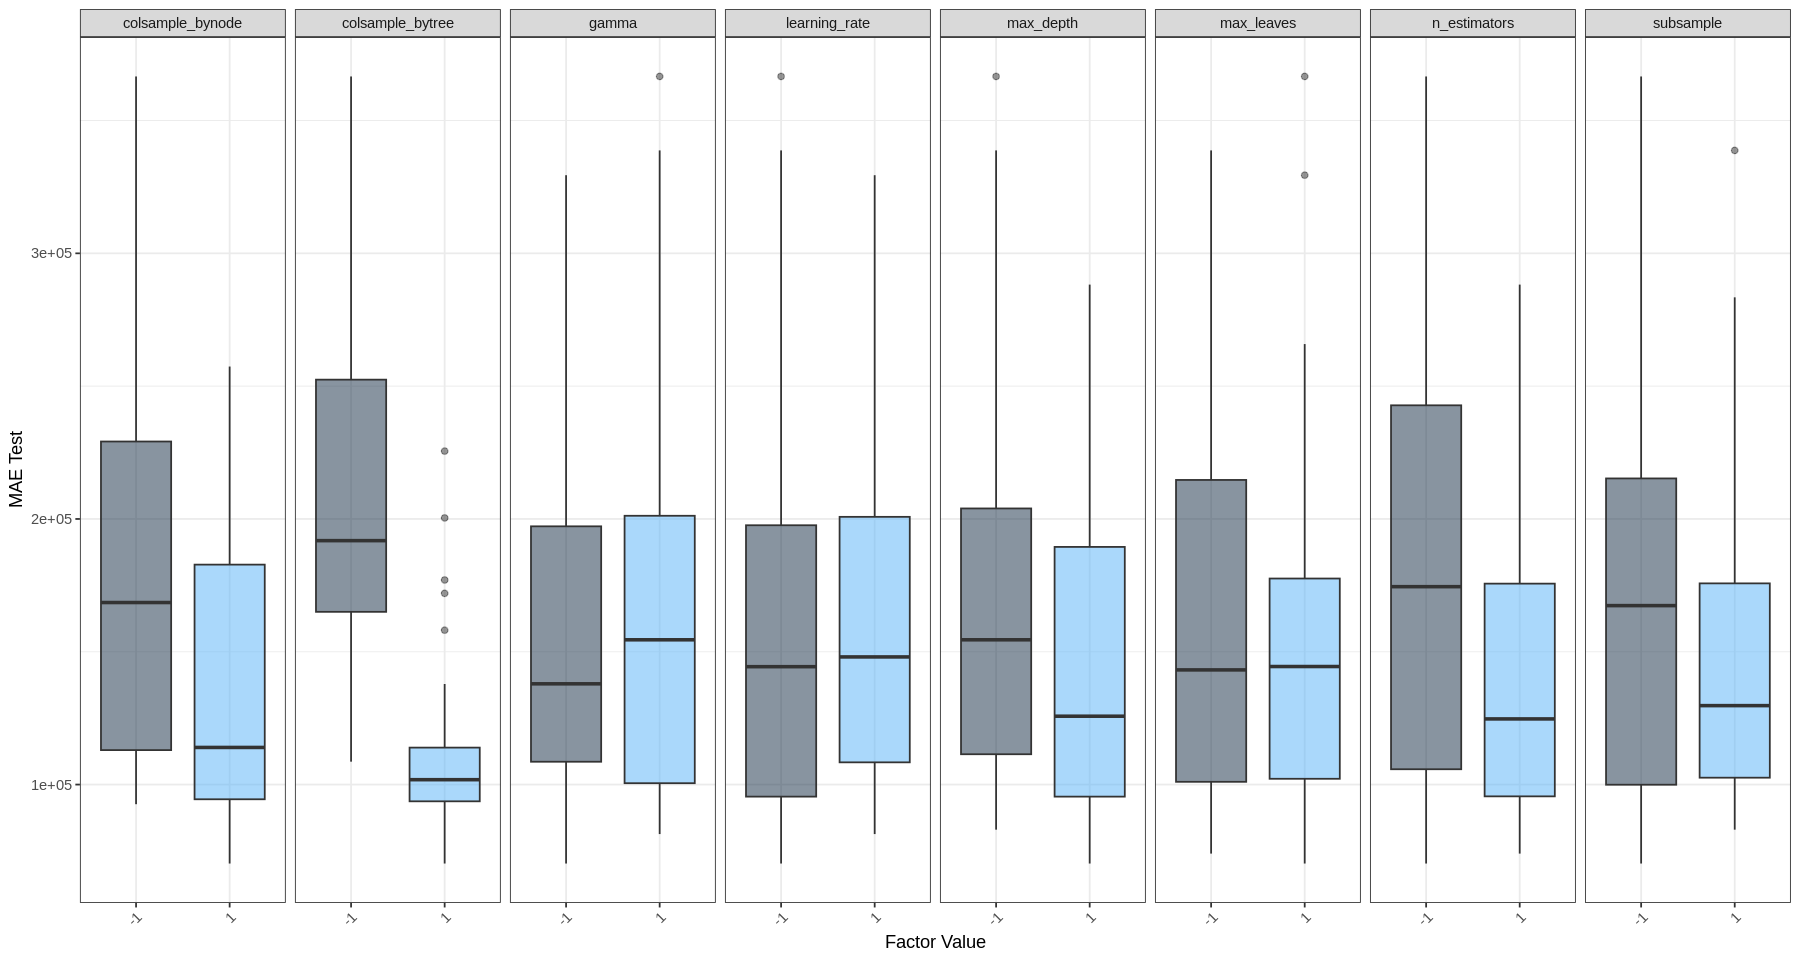

In [ ]:
# disclaimer: ChatGPT generated code snippet ©️  (but not worth it --> https://i.redd.it/4e7ywl1kj74a1.png)

df_long <- design %>% gather(key = "Factor", value = "Value", -test_mae)

options(repr.plot.width=15, repr.plot.height=8)
ggplot(df_long, aes(x = factor(Value), y = test_mae, fill = Value)) +
  geom_boxplot(alpha=0.5) +
  facet_grid(. ~ Factor, shrink=FALSE) +
  labs(x = "Factor Value", y = "MAE Test") +
  theme_bw() +
  theme(legend.position = "none") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

In [ ]:
anova <- aov(test_mae~.,design)
summary(anova)

                 Df    Sum Sq   Mean Sq F value   Pr(>F)    
colsample_bytree  1 1.455e+11 1.455e+11  92.359 2.27e-13 ***
colsample_bynode  1 3.370e+10 3.370e+10  21.389 2.32e-05 ***
max_depth         1 8.819e+09 8.819e+09   5.598   0.0215 *  
learning_rate     1 1.743e+08 1.743e+08   0.111   0.7407    
n_estimators      1 3.264e+10 3.264e+10  20.716 2.99e-05 ***
subsample         1 6.653e+09 6.653e+09   4.223   0.0446 *  
gamma             1 6.210e+08 6.210e+08   0.394   0.5327    
max_leaves        1 6.053e+08 6.053e+08   0.384   0.5379    
Residuals        55 8.665e+10 1.575e+09                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [ ]:
lm_for_coeffs <- lm(test_mae~., data=design)
effects <-as.data.frame(2*lm_for_coeffs$coefficients)
names(effects)[1] <- 'Main Effects'
head(effects, 9)

,Main Effects
,<dbl>
(Intercept),321002.763
colsample_bytree,-95362.753
colsample_bynode,-45891.384
max_depth,-23477.622
learning_rate,3300.787
n_estimators,-45163.869
subsample,-20391.602
gamma,6230.058
max_leaves,-6150.659


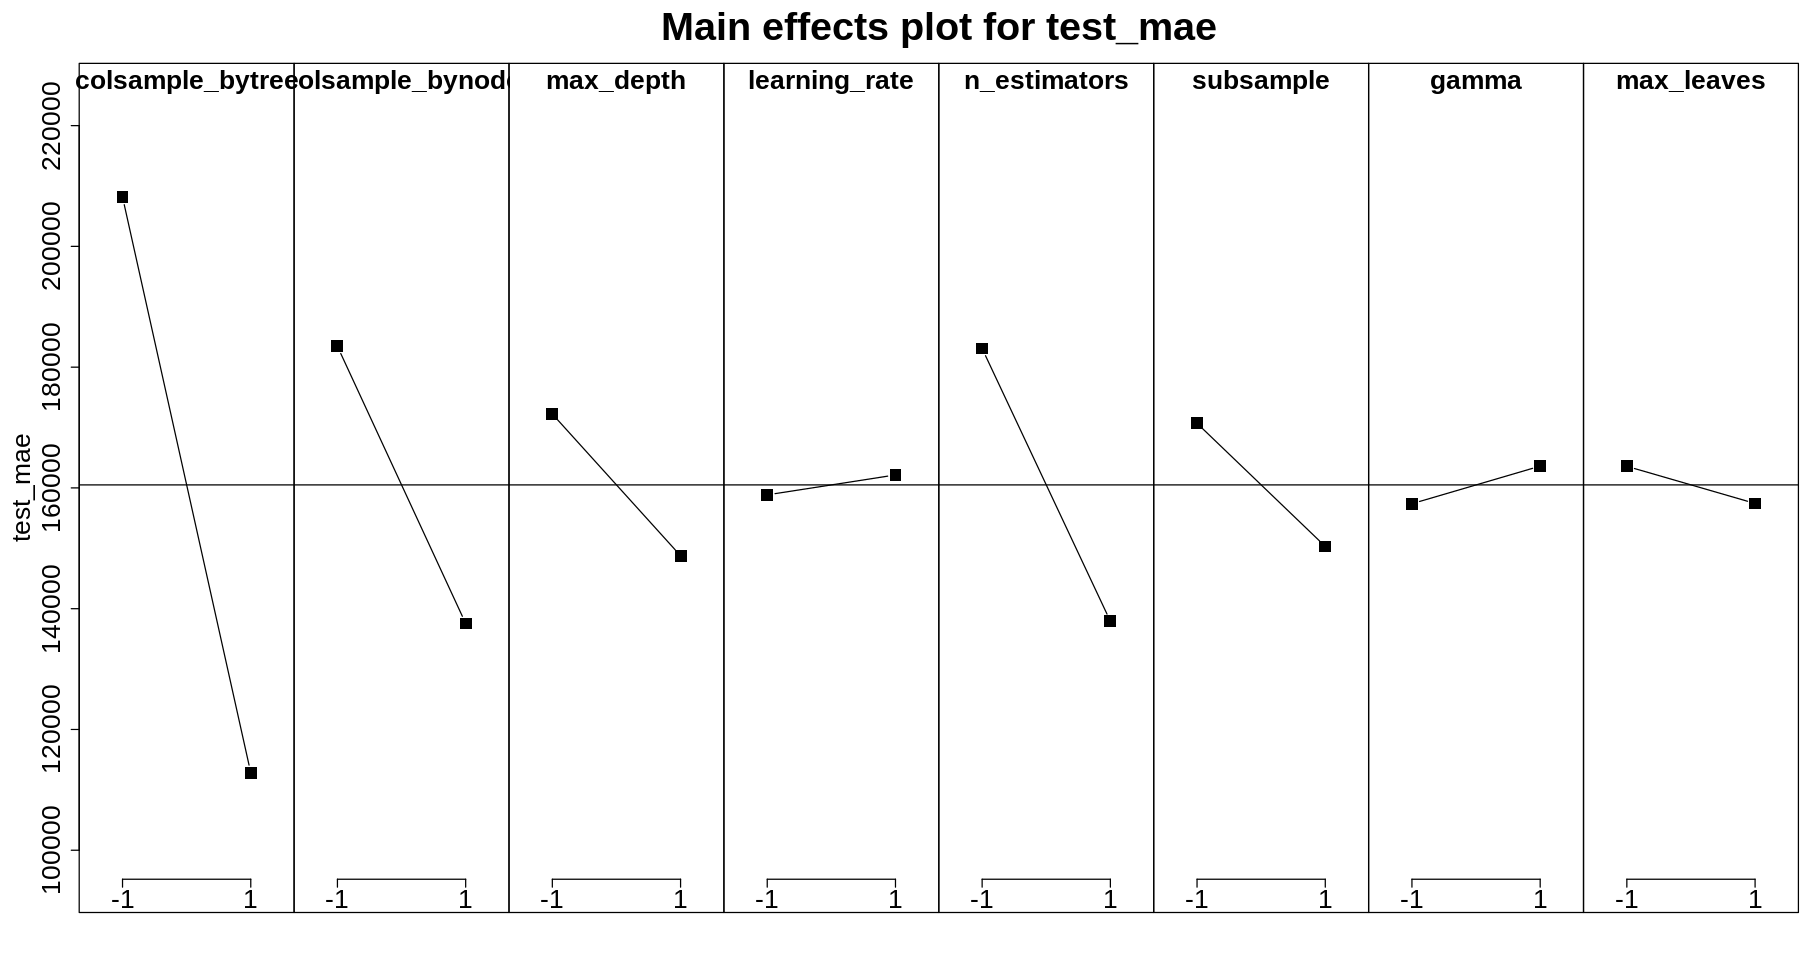

In [ ]:
MEPlot(design, cex.xax = 2, cex.main = 2)

Graf hlavných efektov poukazuje na to, že medzi navplyvnejšie
faktory patrí `colsample_bytree`, `colsample_bynode`, a `n_estimators`. Nutné je dodať, že takáto interpretácia v zmysle hlavných efektov bude možná len v prípade, že interakcie nebudú pozorované. Pokračujme teda grafickou analýzou interakcii.


# Grafická analýza významných faktorov a ich interakcii

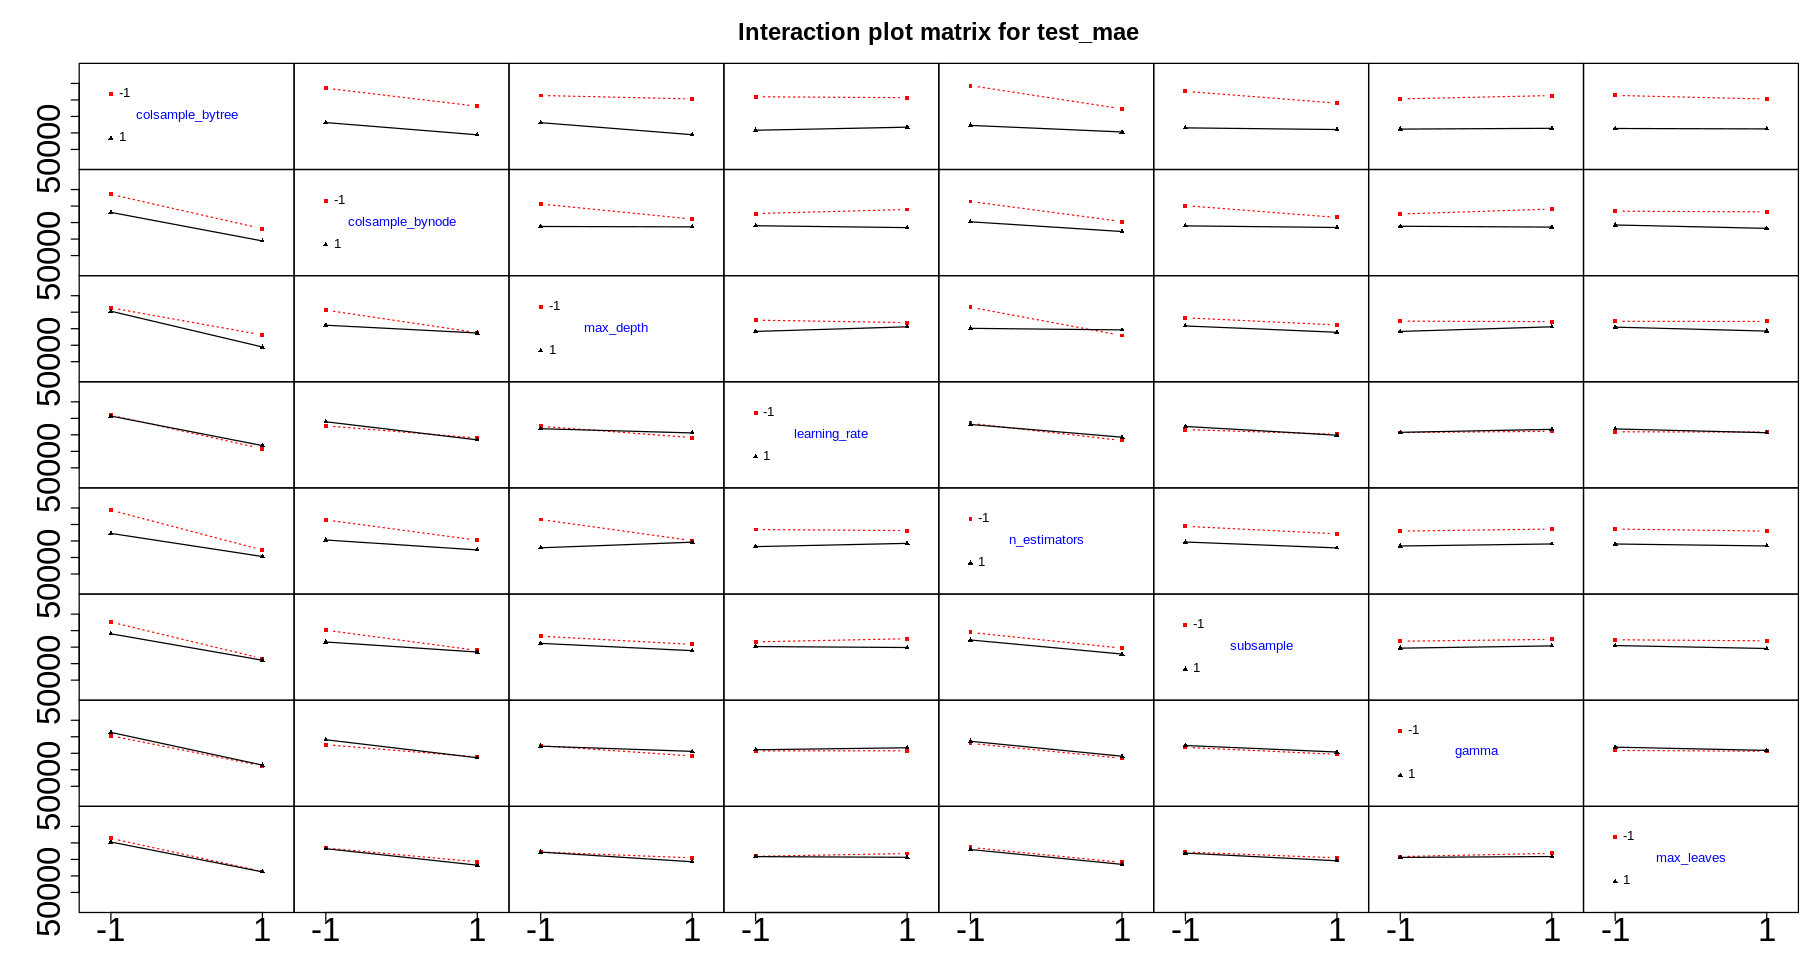

In [ ]:
IAPlot(design, cex.xax = 2.5, cex.main = 2.5)

Podľa interakčného grafu sa zdá, že `colsample_bytree`, `colsample_bynode`, a `n_estimators` faktory vykazujú čiastočné interakcie prvého rádu so všetkými ostatnými skúmanými faktormi. Verifikácie tejto hypotézy bude vykonaná pomocou ANOVA analýzy.


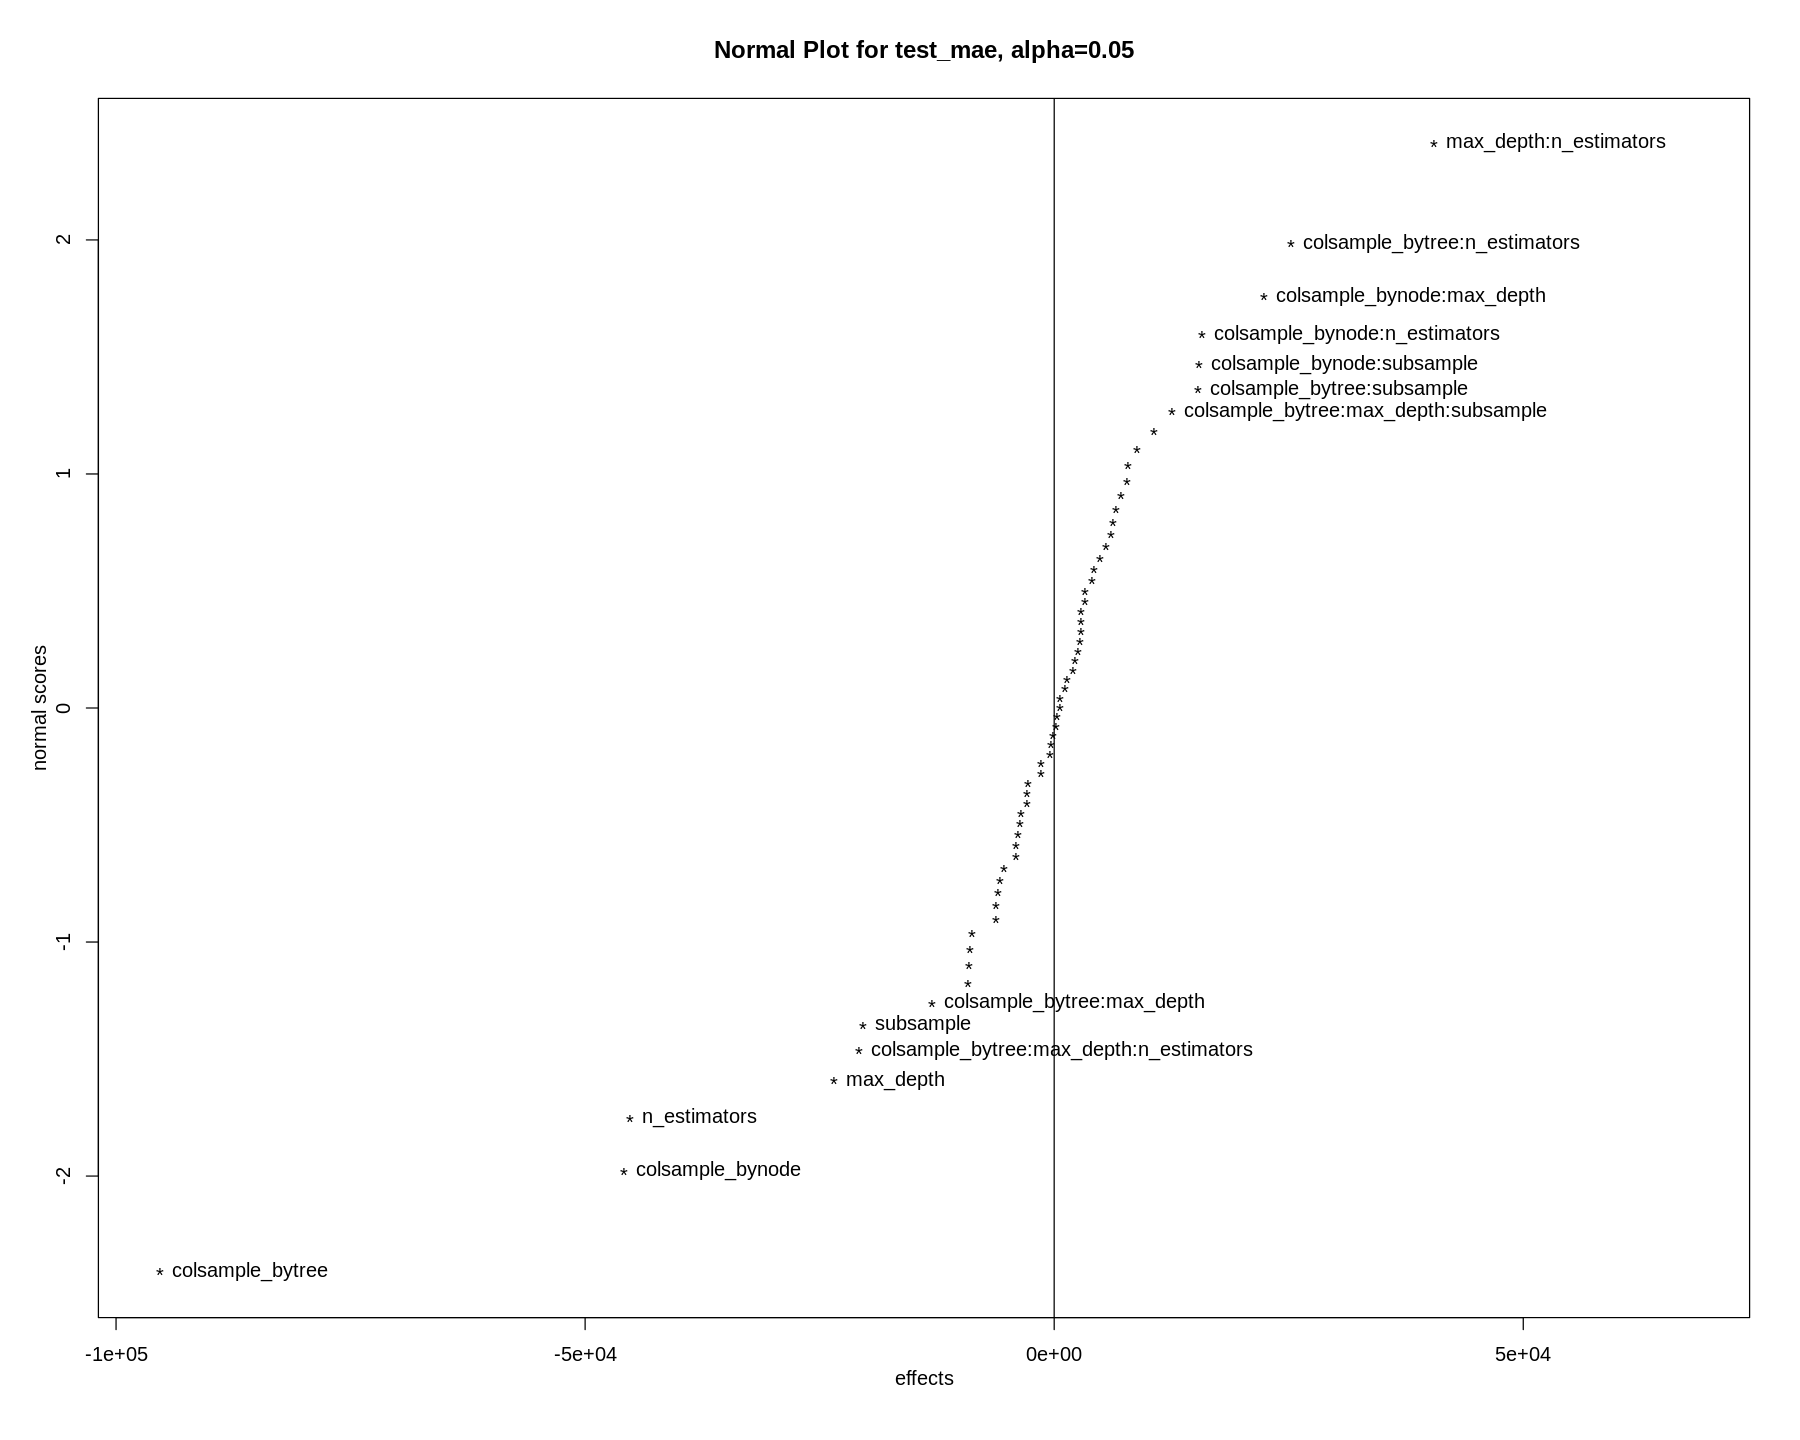

In [ ]:
# Daniel plot
options(repr.plot.width=15, repr.plot.height=12)

DP = DanielPlot(design)
qqline(DanielPlot(design)$y)


Podľa teórie patria medzi významné faktory tie ktoré sa výrazne ďaleko od `normálnej priamky` a teda v našom prípade tento graf opäť okrem iného poukazuje na významnosť faktorov
`colsample_bytree`, `colsample_bynode`, `n_estimators` a tiež niektorých interakcii ako napr. `max_depth:n_estimators` čo sa týka ich vplyvu na výslednú hodnotu testovacej metriky MAE.


In [ ]:
# alternative to extract main effects from Daniel plot

effects <- cbind(DP$effect, DP$x)
effects[1:9,]

colsample_bytree,-95362.7532673922
colsample_bynode,-45891.3835943857
max_depth,-23477.6216499695
learning_rate,3300.78653885274
n_estimators,-45163.8687830553
subsample,-20391.6020646867
gamma,6230.05768155003
max_leaves,-6150.65895163751
colsample_bytree:colsample_bynode,8805.09308253661


# ANOVA

Najprv nafitujeme model so všetkými premennými a ich  interakciami prvého rádu a vylúčime tie ktoré nie sú významné.

In [ ]:
# Resolution V factorial design means that 3 way interactions are aliased
# with 2 way interactions, hence we can't estimate them.
#Any higher interaction is then also aliased.
# First attempt model:
summary(aov(test_mae~ (.)^2 +
                     colsample_bytree:max_depth:subsample +
                     colsample_bytree:max_depth:n_estimators, data=design))

                                        Df    Sum Sq   Mean Sq F value   Pr(>F)
colsample_bytree                         1 1.455e+11 1.455e+11 474.971  < 2e-16
colsample_bynode                         1 3.370e+10 3.370e+10 109.995 1.22e-10
max_depth                                1 8.819e+09 8.819e+09  28.788 1.45e-05
learning_rate                            1 1.743e+08 1.743e+08   0.569  0.45769
n_estimators                             1 3.264e+10 3.264e+10 106.535 1.69e-10
subsample                                1 6.653e+09 6.653e+09  21.718 8.99e-05
gamma                                    1 6.210e+08 6.210e+08   2.027  0.16687
max_leaves                               1 6.053e+08 6.053e+08   1.976  0.17214
colsample_bytree:colsample_bynode        1 1.240e+09 1.240e+09   4.049  0.05508
colsample_bytree:max_depth               1 2.711e+09 2.711e+09   8.849  0.00642
colsample_bytree:learning_rate           1 5.792e+08 5.792e+08   1.891  0.18133
colsample_bytree:n_estimators           

In [ ]:

# Next Model
summary(aov(test_mae~colsample_bytree +
                      colsample_bynode +
                      subsample + max_depth + n_estimators +

                     colsample_bytree:max_depth +
                      colsample_bytree:n_estimators +
                      colsample_bytree:subsample +
                      colsample_bynode:max_depth +
                     colsample_bynode:n_estimators +
                      colsample_bynode:subsample +
                        colsample_bynode:learning_rate+
                      max_depth:n_estimators +
                      max_depth:learning_rate+
                     colsample_bytree:max_depth:subsample +
                     colsample_bytree:max_depth:n_estimators, data=design))

                                        Df    Sum Sq   Mean Sq F value   Pr(>F)
colsample_bytree                         1 1.455e+11 1.455e+11 405.866  < 2e-16
colsample_bynode                         1 3.370e+10 3.370e+10  93.991 8.62e-13
subsample                                1 6.653e+09 6.653e+09  18.558 8.34e-05
max_depth                                1 8.819e+09 8.819e+09  24.600 9.63e-06
n_estimators                             1 3.264e+10 3.264e+10  91.035 1.43e-12
colsample_bytree:max_depth               1 2.711e+09 2.711e+09   7.561  0.00844
colsample_bytree:n_estimators            1 1.023e+10 1.023e+10  28.523 2.64e-06
colsample_bytree:subsample               1 3.749e+09 3.749e+09  10.458  0.00224
colsample_bynode:max_depth               1 7.992e+09 7.992e+09  22.291 2.14e-05
colsample_bynode:n_estimators            1 3.954e+09 3.954e+09  11.028  0.00174
colsample_bynode:subsample               1 3.825e+09 3.825e+09  10.669  0.00204
colsample_bynode:learning_rate          

Po nafitovaní modelu sa zdá, že interakcia `colsample_bynode:learning_rate` už nie je významná preto ju vylúčime z finálneho modelu

In [ ]:
# Final Model

final_model <- aov(test_mae~colsample_bytree +
                      colsample_bynode +
                      subsample + max_depth + n_estimators +

                     colsample_bytree:max_depth +
                      colsample_bytree:n_estimators +
                      colsample_bytree:subsample +
                      colsample_bynode:max_depth +
                     colsample_bynode:n_estimators +
                      colsample_bynode:subsample +
                      max_depth:n_estimators +
                      max_depth:learning_rate+
                     colsample_bytree:max_depth:subsample +
                     colsample_bytree:max_depth:n_estimators, data=design)
summary(final_model)

                                        Df    Sum Sq   Mean Sq F value   Pr(>F)
colsample_bytree                         1 1.455e+11 1.455e+11 384.761  < 2e-16
colsample_bynode                         1 3.370e+10 3.370e+10  89.104 1.62e-12
subsample                                1 6.653e+09 6.653e+09  17.593 0.000117
max_depth                                1 8.819e+09 8.819e+09  23.321 1.44e-05
n_estimators                             1 3.264e+10 3.264e+10  86.301 2.67e-12
colsample_bytree:max_depth               1 2.711e+09 2.711e+09   7.168 0.010126
colsample_bytree:n_estimators            1 1.023e+10 1.023e+10  27.040 4.07e-06
colsample_bytree:subsample               1 3.749e+09 3.749e+09   9.915 0.002819
colsample_bynode:max_depth               1 7.992e+09 7.992e+09  21.132 3.13e-05
colsample_bynode:n_estimators            1 3.954e+09 3.954e+09  10.455 0.002215
colsample_bynode:subsample               1 3.825e+09 3.825e+09  10.115 0.002577
max_depth:n_estimators                  

Pomocou ANOVA analýzy sme dospeli k veľmi podobným záverom ohľadom modelu ako v prípade grafickej analýzy. Vidíme, že na výslednú hodnotu metriky MAE nevplývajú len hlavné efekty pár faktorov ale aj ich interakcie prvého a druhého rádu čo významne sťažuje interpretabilitu jednotlivých faktorov. Našou úlohou ale nie je interpretovať účinok jednotlivých faktorov ale nájsť vhodný model na lineárnu aproximáciu response funkcie ktorou je v našom prípade MAE metrika.
Pokračujme teda s validáciou predpokladov ANOVA...

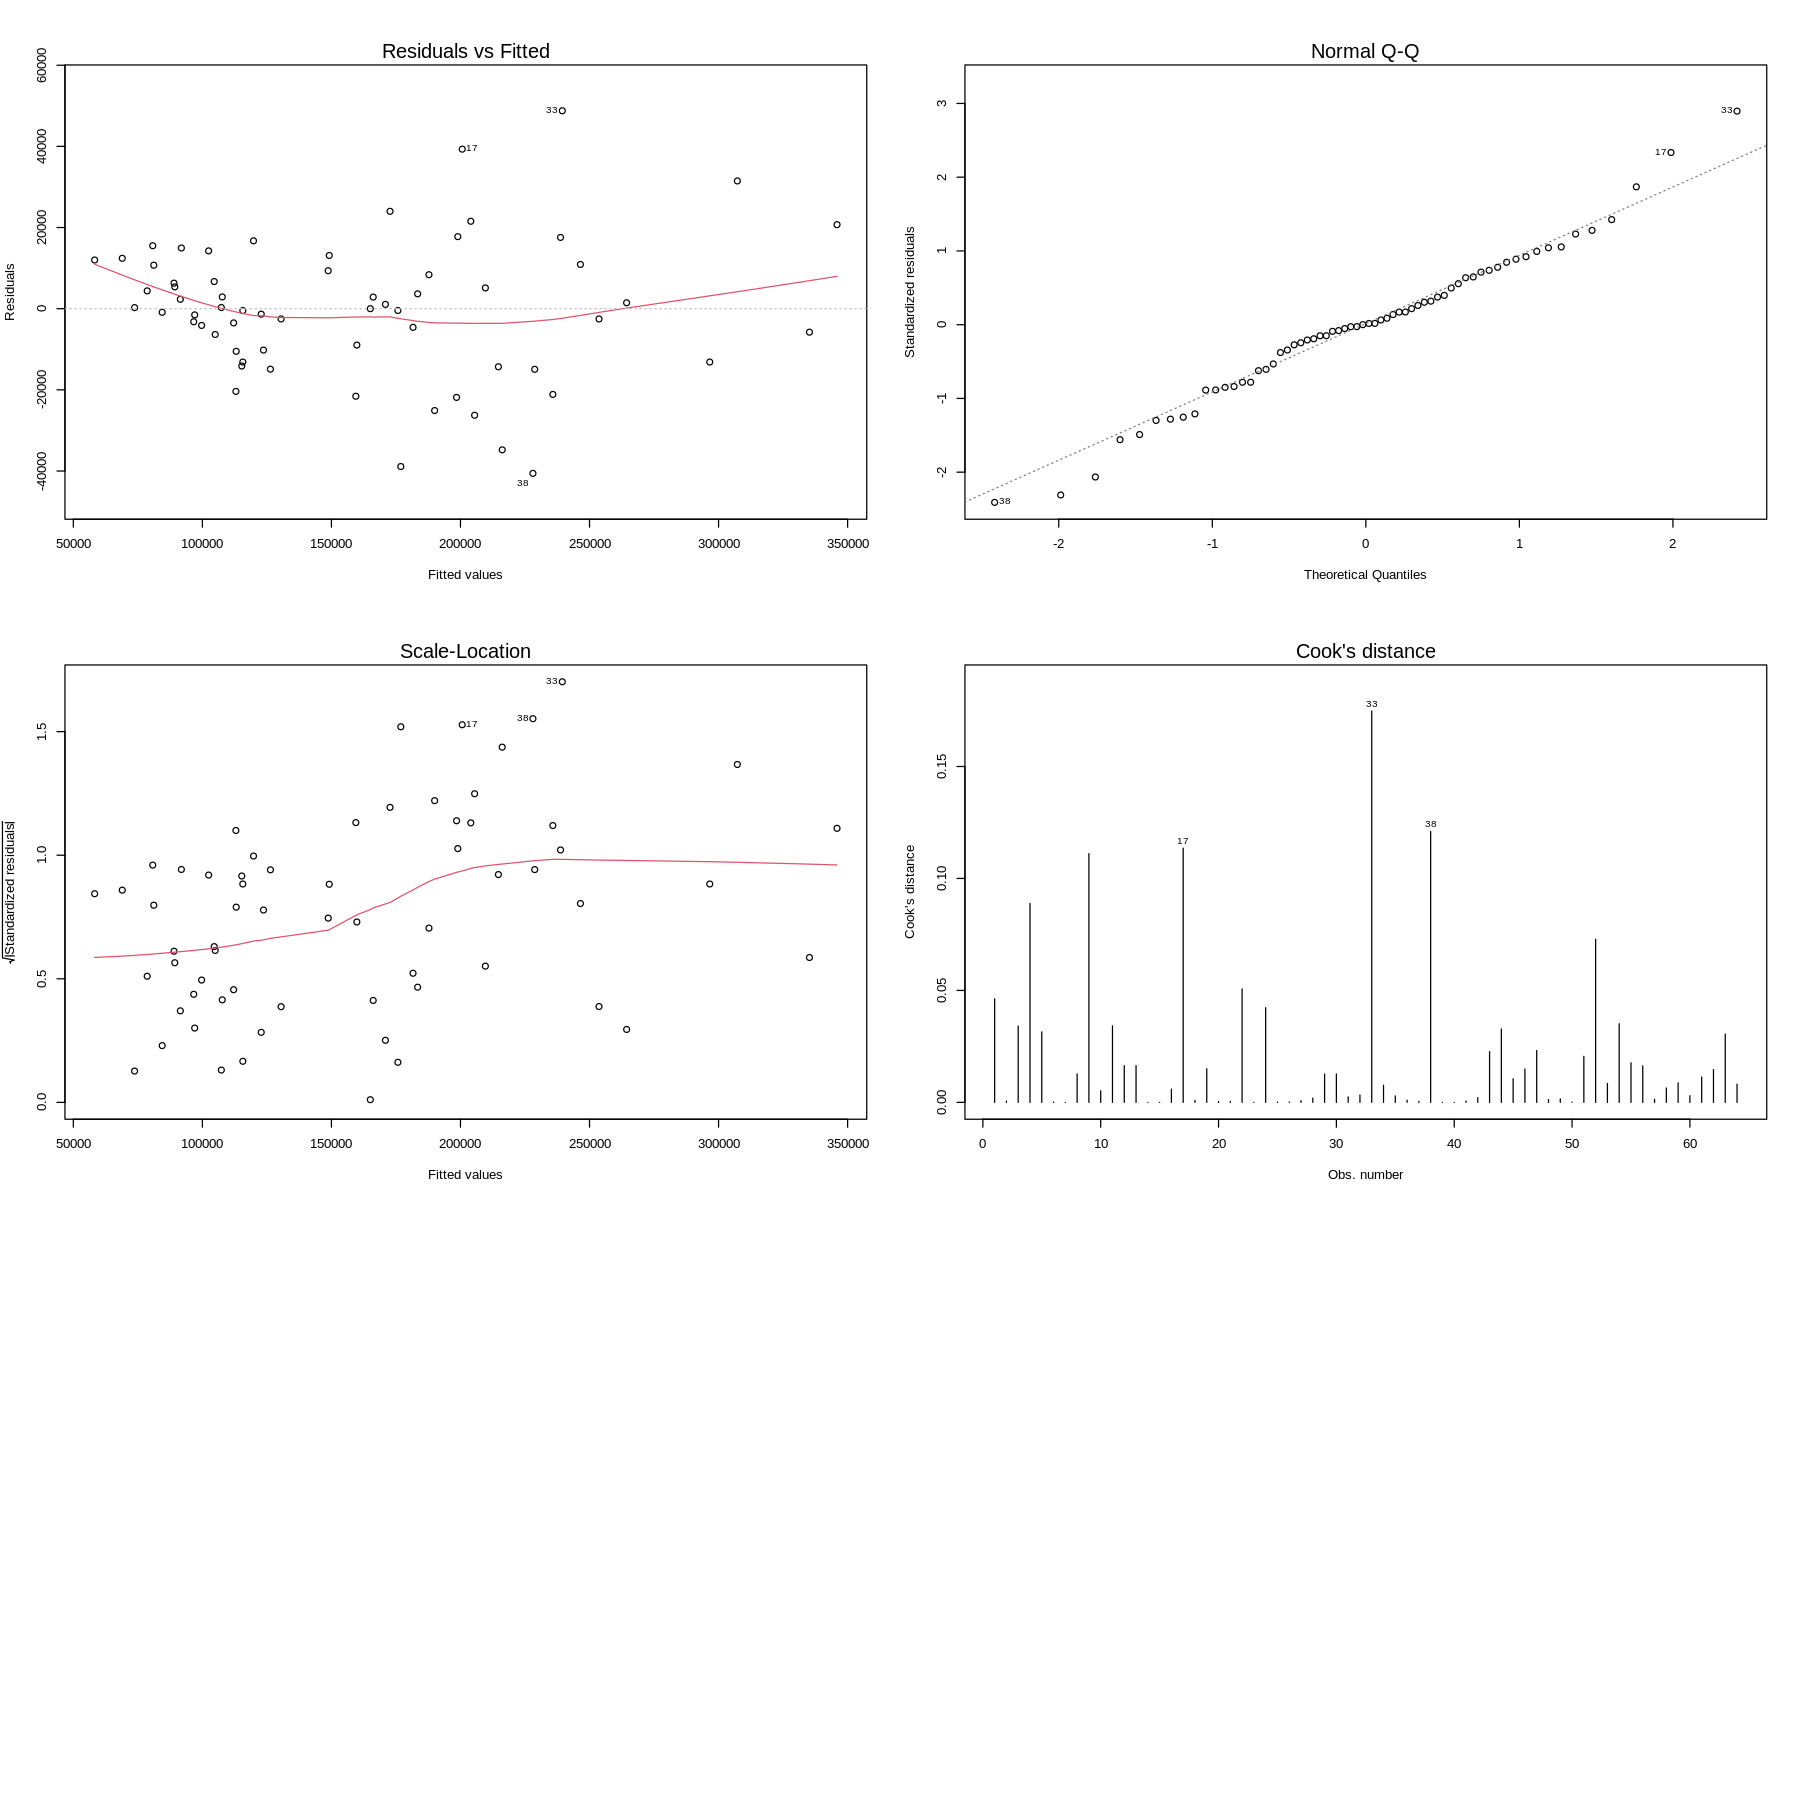

In [ ]:
par(mfrow = c(3,2))
options(repr.plot.width = 15, repr.plot.height = 15)

plot(final_model, which=c(1,2,3,4))

Celkovo z grafov nie je vidieť nič podozrivé preto pokračujme ďalej s analýzou...

# Test lineárnej závislosti pomocou meraní v centrálnych bodoch

Keďže už máme určený finálny linárny model, môžme použiť dáta aby sme overili či závislosť MAE nie je ovplyvnená aj kvadratickými závislosťami jednotlivých faktorov. Na toto použijeme dodatočné merania v centrálnych bodoch.

In [ ]:
# dataframe with center point measurements only
data_center_only = measured_design[65:69, ]
data_center_only

,colsample_bytree,colsample_bynode,max_depth,learning_rate,n_estimators,subsample,gamma,max_leaves,test_mae,train_mae
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
65,0,0,0,0,0,0,0,0,100885.3,10149.37
66,0,0,0,0,0,0,0,0,100885.3,10149.37
67,0,0,0,0,0,0,0,0,100885.3,10149.37
68,0,0,0,0,0,0,0,0,100885.3,10149.37
69,0,0,0,0,0,0,0,0,100885.3,10149.37


In [ ]:
mean_mae = mean(design$test_mae)
mean_center = mean(data_center_only$test_mae)


mean_mae - mean_center

ss_pure_quadratic = (64*5)*(mean_center-mean_mae)*(mean_center-mean_mae) / (64+5)

#ss_pure_quadratic

[1] 59616.1

Vidíme, že rozdiel priemernej odozvy v centrálnych bodoch a priemernej odozvy ostatných meraní je zhruba 60000 čo poukazuje na to, že závislosť nie je čisto lineárna. Overme to ešte pomocou F-testu v lineárnom modely...

In [ ]:
isCenter = c(rep(0,times=64),rep(1,times=5), rep(0,times=16))
measured_design$isCenter = isCenter

summary(aov(test_mae~colsample_bytree +
                      colsample_bynode +
                      subsample + max_depth + n_estimators +
                      isCenter+
                     colsample_bytree:max_depth +
                      colsample_bytree:n_estimators +
                      colsample_bytree:subsample +
                      colsample_bynode:max_depth +
                     colsample_bynode:n_estimators +
                      colsample_bynode:subsample +
                      max_depth:n_estimators +
                      max_depth:learning_rate+
                     colsample_bytree:max_depth:subsample +
                     colsample_bytree:max_depth:n_estimators, data=measured_design[1:69, ]))



                                        Df    Sum Sq   Mean Sq F value   Pr(>F)
colsample_bytree                         1 1.455e+11 1.455e+11 416.825  < 2e-16
colsample_bynode                         1 3.370e+10 3.370e+10  96.529 1.91e-13
subsample                                1 6.653e+09 6.653e+09  19.059 6.05e-05
max_depth                                1 8.819e+09 8.819e+09  25.264 6.28e-06
n_estimators                             1 3.264e+10 3.264e+10  93.493 3.28e-13
isCenter                                 1 1.648e+10 1.648e+10  47.218 7.93e-09
colsample_bytree:max_depth               1 2.711e+09 2.711e+09   7.766  0.00742
colsample_bytree:n_estimators            1 1.023e+10 1.023e+10  29.293 1.60e-06
colsample_bytree:subsample               1 3.749e+09 3.749e+09  10.741  0.00187
colsample_bynode:max_depth               1 7.992e+09 7.992e+09  22.893 1.46e-05
colsample_bynode:n_estimators            1 3.954e+09 3.954e+09  11.326  0.00144
colsample_bynode:subsample              

Výsledok ANOVA analýzy potrvrdzuje, že závislosť MAE metriky na faktoroch nie je čisto lineárna ale obsahuje aj
kvadratické členy.

# Lineárny model

Nakoľko predchadzajúca ANOVA analýza poukazuje na kvadratickú závislosť tak sa pokúsime nafitovať nový lineárny model aj s kvadratickými členmi. Pre tento účel bolo vykonaných dodatočných 16 meraní pomocou center composite dizajnu.


In [ ]:
lin_model <- lm(test_mae~colsample_bytree +
                      colsample_bynode +
                      subsample + max_depth +
                      n_estimators +

                      I(max_depth^2)+
                        #I(n_estimators^2)+
                        #I(subsample^2)+
                        I(colsample_bynode^2) + #I(colsample_bytree^2)+

                     colsample_bytree:max_depth +
                      colsample_bytree:n_estimators +
                      colsample_bytree:subsample +
                      colsample_bynode:max_depth +
                     colsample_bynode:n_estimators +
                      colsample_bynode:subsample +
                      max_depth:n_estimators +
                      max_depth:learning_rate+
                     colsample_bytree:max_depth:subsample +
                     colsample_bytree:max_depth:n_estimators
                   , data=measured_design) # <- contains also center composite measurements


summary(lin_model)


Call:
lm.default(formula = test_mae ~ colsample_bytree + colsample_bynode + 
    subsample + max_depth + n_estimators + I(max_depth^2) + I(colsample_bynode^2) + 
    colsample_bytree:max_depth + colsample_bytree:n_estimators + 
    colsample_bytree:subsample + colsample_bynode:max_depth + 
    colsample_bynode:n_estimators + colsample_bynode:subsample + 
    max_depth:n_estimators + max_depth:learning_rate + colsample_bytree:max_depth:subsample + 
    colsample_bytree:max_depth:n_estimators, data = measured_design)

Residuals:
   Min     1Q Median     3Q    Max 
-47931 -10556   -730   9809  49745 

Coefficients:
                                        Estimate Std. Error t value Pr(>|t|)
(Intercept)                               101615       4784  21.238  < 2e-16
colsample_bytree                          -46226       2498 -18.508  < 2e-16
colsample_bynode                          -22804       2498  -9.131 2.23e-13
subsample                                 -10166       2498  -4.071 0.0

Zdá sa teda, že závislosť je kvadratická v `colsample_bynode` a `max_depth` premennej. Aby sme mohli v ďalšej analýze použiť aproximáciu kvadratickou závislosťou tak vylúčime interakcie druhého rádu, konkrétne `colsample_bytree:subsample:max_depth` a `colsample_bytree:max_depth:n_estimators`. Aj bez týchto členov model dáva relatívne vysokú hodnotu R2.

In [ ]:
final_lin_model <- lm(test_mae~colsample_bytree +
                      colsample_bynode +
                      subsample + max_depth +
                      n_estimators +

                      # add other (non-significant)factors for quadrature
                      # -----------------------
                        #I(n_estimators^2)+
                        #I(subsample^2)+
                       #I(colsample_bytree^2)+
                       #colsample_bytree:colsample_bynode+
                       #max_depth:subsample+
                       #n_estimators:subsample+
                    #---------------------------

                     colsample_bytree:max_depth +
                      colsample_bytree:n_estimators +
                      colsample_bytree:subsample +
                      colsample_bynode:max_depth +
                     colsample_bynode:n_estimators +
                      colsample_bynode:subsample +
                      max_depth:n_estimators +


                     I(colsample_bynode^2)+
                      I(max_depth^2)
                     #colsample_bytree:max_depth:subsample +
                     #colsample_bytree:max_depth:n_estimators
                   , data=measured_design) # <- data with center and center composite design


summary(final_lin_model)


Call:
lm.default(formula = test_mae ~ colsample_bytree + colsample_bynode + 
    subsample + max_depth + n_estimators + colsample_bytree:max_depth + 
    colsample_bytree:n_estimators + colsample_bytree:subsample + 
    colsample_bynode:max_depth + colsample_bynode:n_estimators + 
    colsample_bynode:subsample + max_depth:n_estimators + I(colsample_bynode^2) + 
    I(max_depth^2), data = measured_design)

Residuals:
   Min     1Q Median     3Q    Max 
-48214 -12906   -944   9952  71759 

Coefficients:
                              Estimate Std. Error t value Pr(>|t|)    
(Intercept)                     101615       5555  18.292  < 2e-16 ***
colsample_bytree                -46226       2900 -15.941  < 2e-16 ***
colsample_bynode                -22804       2900  -7.864 3.25e-11 ***
subsample                       -10166       2900  -3.506 0.000799 ***
max_depth                       -11307       2900  -3.899 0.000219 ***
n_estimators                    -21898       2900  -7.551 1.22e-1

In [ ]:
anova(final_lin_model, lin_model)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,70,38850375257,NA,NA,NA,NA
2,67,27583541753,3,11266833505,9.122322,3.825641e-05


Model s interakciami druhého rádu je síce signifikantne lepší ale tieto interakcie by nám neumožnili použiť kvadratickú nadplochu na response surface analýzu.

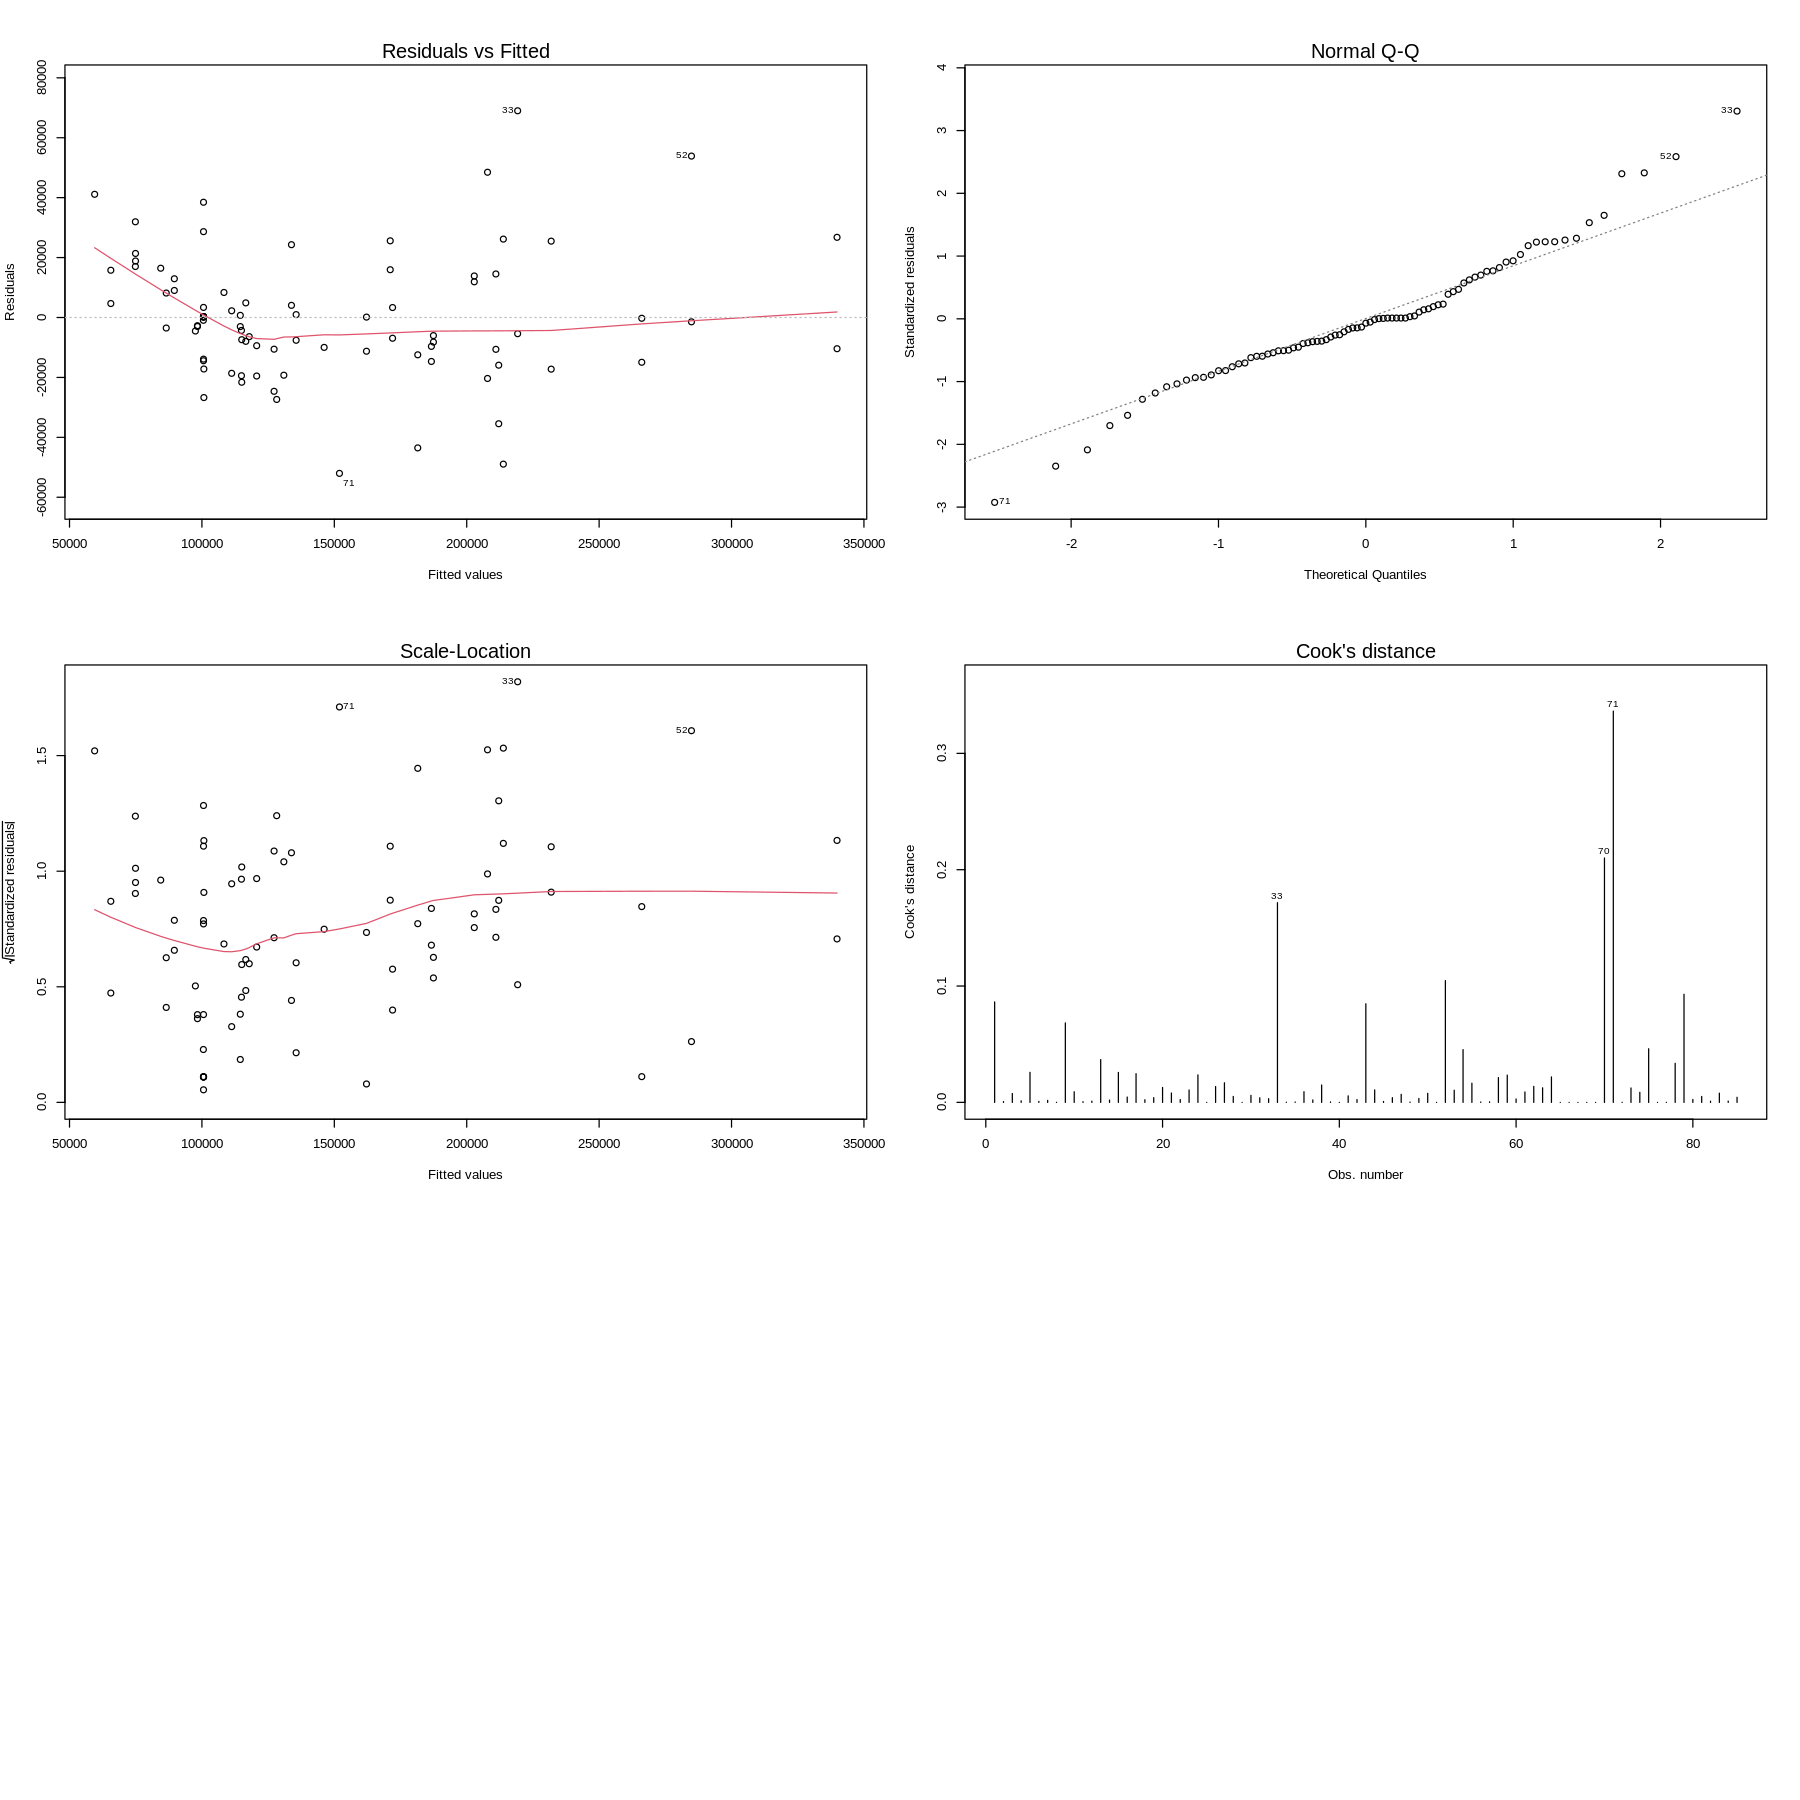

In [ ]:
par(mfrow = c(3,2))
options(repr.plot.width = 15, repr.plot.height = 15)

plot(final_lin_model, which=c(1,2,3,4))

Graf residual vs fitted nevykazuje značné vzory. Na druhú stranu QQ-plot poukazuje na to, že rezidua prislúchajúce pozorovaniam 33 a 52 sa mierne odlišujú od očakávanej normálnej distribúcie. Tieto dve pozorovania sú zároveň pákovými bodmi. Celkovo ale nevidím dôvod ich vylučovať z analýzy.

In [ ]:
#mapped_data <- data %>% mutate(
#                           colsample_bytree = (colsample_bytree-0.75)/0.25,
#                           colsample_bynode = (colsample_bynode-0.75)/0.25,
#                           subsample = (subsample-0.75)/0.25,
#                           max_depth = (max_depth-9)/6,
#                           n_estimators = (n_estimators-400)/300,
#                           learning_rate = (learning_rate-0.119995)/0.030005,
#                           test_mae = test_mae
#                           )

# Response surface analýza

Nakoľko závisloť MAE je aj kvadratická tak použitie čisto lineárneho modelu by určite neprinieslo vhodnú aproximáciu gradientu. Ďalšími možnosťami sú výpočet gradientu kvadratickej plochy pomocou plne kvadratického modelu a použitie tohto gradientu na nájdenie nového nastavenia. Problém je, že gradient kvadratickej nadplochy závisí na bode v ktorom sa nachádzame (narozdiel od lineárnej nadplochy)
a preto sekvenčné aplikovanie gradientného zostupu by bolo časovo dosť náročné.

Z tohto dôvodu sa pokúsime nájsť optimum len pomocou stacionárneho bodu, v oblasti záujmu definovanej na začiatku protokolu a s pomocou vizualizácii.

Podotknime ešte, že dimenzionalita problému sa znížila z 8  na 5 pretože faktory `gamma`, `learning_rate` a `max_leaves` sa ukázali byť nevýznamnými.

V ďalšom postupe nafitujeme plne kvadratický model s 5 faktormi pričom použijeme aj tie nevýznamné aby sme mali aspoň nejaký odhad parametrov gradientu kvadratickej nadplochy nutný na výpočet stacionárneho bodu.

In [ ]:
# fit full quadratic model (included also non significant features)

fqm <- lm(test_mae~colsample_bytree +
                      colsample_bynode +
                      subsample + max_depth +
                      #n_estimators +

                      # add other (non-significant)factors for quadrature
                      # -----------------------
                        I(n_estimators^2)+
                        I(subsample^2)+
                       I(colsample_bytree^2)+
                       colsample_bytree:colsample_bynode+
                       max_depth:subsample+
                       n_estimators:subsample+
                    #---------------------------

                     colsample_bytree:max_depth +
                      colsample_bytree:n_estimators +
                      colsample_bytree:subsample +
                      colsample_bynode:max_depth +
                     colsample_bynode:n_estimators +
                      colsample_bynode:subsample +
                      max_depth:n_estimators +


                     I(colsample_bynode^2)+
                      I(max_depth^2)
                     #colsample_bytree:max_depth:subsample +
                     #colsample_bytree:max_depth:n_estimators
                   , data=measured_design) # <- data with center and center composite design


summary(fqm)


Call:
lm.default(formula = test_mae ~ colsample_bytree + colsample_bynode + 
    subsample + max_depth + I(n_estimators^2) + I(subsample^2) + 
    I(colsample_bytree^2) + colsample_bytree:colsample_bynode + 
    max_depth:subsample + n_estimators:subsample + colsample_bytree:max_depth + 
    colsample_bytree:n_estimators + colsample_bytree:subsample + 
    colsample_bynode:max_depth + colsample_bynode:n_estimators + 
    colsample_bynode:subsample + max_depth:n_estimators + I(colsample_bynode^2) + 
    I(max_depth^2), data = measured_design)

Residuals:
   Min     1Q Median     3Q    Max 
-57363 -21765     69  12488  75774 

Coefficients:
                                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)                       100601.5     7797.5  12.902  < 2e-16 ***
colsample_bytree                  -46225.9     3999.1 -11.559  < 2e-16 ***
colsample_bynode                  -22804.3     3999.1  -5.702 3.12e-07 ***
subsample                         -10166.3     3999.

In [ ]:
 # full quadratic model
 # cs_bt, cs_bn, sub, m_d, n_estim
 b = matrix(c(fqm$coeff[2],fqm$coeff[3], fqm$coeff[4], fqm$coeff[5], fqm$coeff[6]),5,1)

          #   colsmp_bytre | colsmp_bynd    | subsample     |   max_depth   |   n_estimators
 B = matrix(c(fqm$coeff[9], fqm$coeff[12]/2, fqm$coeff[17]/2, fqm$coeff[15]/2, fqm$coeff[16]/2,
              fqm$coeff[12]/2, fqm$coeff[10], fqm$coeff[20]/2, fqm$coeff[18]/2 ,fqm$coeff[19]/2,
              fqm$coeff[17]/2, fqm$coeff[20]/2,fqm$coeff[8],fqm$coeff[13]/2,fqm$coeff[14]/2,
              fqm$coeff[15]/2, fqm$coeff[18]/2,fqm$coeff[13]/2,fqm$coeff[11],fqm$coeff[21]/2,
              fqm$coeff[16]/2,fqm$coeff[19]/2, fqm$coeff[14]/2, fqm$coeff[21]/2, fqm$coeff[7])

              ,5,5)
b
B

-46225.89
-22804.30
-10166.31
-11307.37
-21897.63


5112.896,2201.273,3827.0175,-3254.0910,6320.1275
2201.273,22750.413,3865.4426,5587.2214,3929.9388
3827.018,3865.443,7098.6548,337.7518,629.1499
-3254.091,5587.221,337.7518,19028.8510,10111.4659
6320.128,3929.939,629.1499,10111.4659,5738.6407


In [ ]:
x_stat = -1/2 * solve(B) %*% b

x_stat_natur = c((0.25*x_stat[1]+0.75), (0.25*x_stat[2] +0.75), (0.25*x_stat[3] +0.75),
                  (6*x_stat[4] +9), (300*x_stat[5] +400))

data.frame(colsample_bytree=x_stat[1],colsample_bynode=x_stat[2],
                             subsample=x_stat[3], max_depth=x_stat[4], n_estimators=x_stat[5])

data.frame(colsample_bytree=x_stat_natur[1],colsample_bynode=x_stat_natur[2],
                             subsample=x_stat_natur[3], max_depth=x_stat_natur[4], n_estimators=x_stat_natur[5])

y_stat = predict(fqm,
                  data.frame(colsample_bytree=x_stat[1],colsample_bynode=x_stat[2],
                             subsample=x_stat[3], max_depth=x_stat[4], n_estimators=x_stat[5]))

#x_stat
y_stat

colsample_bytree,colsample_bynode,subsample,max_depth,n_estimators
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.8509476,0.2304441,-0.04055383,-0.9203648,2.439051


colsample_bytree,colsample_bynode,subsample,max_depth,n_estimators
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.9627369,0.807611,0.7398615,3.477811,1131.715


1 
57010.87

In [ ]:
# using library rsm mainly because of nice contour plots
# https://r-inthelab.net/2022/06/15/response-surface-designs-and-their-analysis-with-r/
quad_model <- rsm(test_mae ~ SO(colsample_bytree, colsample_bynode, subsample, max_depth,
                               n_estimators)
                               , data = measured_design)

summary(quad_model)


Call:
rsm(formula = test_mae ~ SO(colsample_bytree, colsample_bynode, 
    subsample, max_depth, n_estimators), data = measured_design)

                                  Estimate Std. Error  t value  Pr(>|t|)    
(Intercept)                       100601.5     5767.8  17.4420 < 2.2e-16 ***
colsample_bytree                  -46225.9     2958.1 -15.6269 < 2.2e-16 ***
colsample_bynode                  -22804.3     2958.1  -7.7091 1.050e-10 ***
subsample                         -10166.3     2958.1  -3.4368 0.0010393 ** 
max_depth                         -11307.4     2958.1  -3.8225 0.0003017 ***
n_estimators                      -21897.6     2958.1  -7.4026 3.644e-10 ***
colsample_bytree:colsample_bynode   4402.6     3004.0   1.4656 0.1476599    
colsample_bytree:subsample          7654.0     3004.0   2.5480 0.0132468 *  
colsample_bytree:max_depth         -6508.2     3004.0  -2.1665 0.0340011 *  
colsample_bytree:n_estimators      12640.3     3004.0   4.2078 8.196e-05 ***
colsample_bynod

Ako vidíme tak stacionárny bod by mal byť vzhľadom k nášmu modelu mimo skúmanej oblasti a to v dimenzii `n_estimators`.

Po vykonaní experimentu s vyššie uvedenými hodnotami hyperparametrov pričom `max_depth` bola nastavená na 3 sme dosiahli hodnotu 90941 MAE. Podľa výsledku `rsm` funkcie vidíme, že lack-of-fit test je signifikantný čo naznačuje neadekvátnosť modelu čo dáva zmysel nakoľko sme vylúčili signifikantné interakcie druhého rádu.

Preskúmajme ešte contour ploty kvadratického modelu...

In [ ]:
quad_model <- rsm(test_mae ~ SO(colsample_bytree, colsample_bynode, subsample, max_depth,
                               n_estimators) + colsample_bytree:max_depth:subsample
                               +
                                colsample_bytree:max_depth:n_estimators
                               , data = measured_design)

summary(quad_model)


Call:
rsm(formula = test_mae ~ SO(colsample_bytree, colsample_bynode, 
    subsample, max_depth, n_estimators) + colsample_bytree:max_depth:subsample + 
    colsample_bytree:max_depth:n_estimators, data = measured_design)

                                        Estimate Std. Error  t value  Pr(>|t|)
(Intercept)                             100601.5     5056.8  19.8942 < 2.2e-16
colsample_bytree                        -46225.9     2593.5 -17.8238 < 2.2e-16
colsample_bynode                        -22804.3     2593.5  -8.7929 1.686e-12
subsample                               -10166.3     2593.5  -3.9199 0.0002239
max_depth                               -11307.4     2593.5  -4.3599 4.995e-05
n_estimators                            -21897.6     2593.5  -8.4433 6.755e-12
colsample_bytree:colsample_bynode         4402.6     2633.7   1.6716 0.0996398
colsample_bytree:subsample                7654.0     2633.7   2.9062 0.0050676
colsample_bytree:max_depth               -6508.2     2633.7  -2.4

In [ ]:
# two-way interactions added for better fit
quad_model2 <- rsm(test_mae ~ SO(colsample_bytree, colsample_bynode, subsample, max_depth,
                               n_estimators) + colsample_bytree:max_depth:subsample
                               +
                                colsample_bytree:max_depth:n_estimators
                               , data = measured_design)

summary(quad_model2)


Call:
rsm(formula = test_mae ~ SO(colsample_bytree, colsample_bynode, 
    subsample, max_depth, n_estimators) + colsample_bytree:max_depth:subsample + 
    colsample_bytree:max_depth:n_estimators, data = measured_design)

                                        Estimate Std. Error  t value  Pr(>|t|)
(Intercept)                             100601.5     5056.8  19.8942 < 2.2e-16
colsample_bytree                        -46225.9     2593.5 -17.8238 < 2.2e-16
colsample_bynode                        -22804.3     2593.5  -8.7929 1.686e-12
subsample                               -10166.3     2593.5  -3.9199 0.0002239
max_depth                               -11307.4     2593.5  -4.3599 4.995e-05
n_estimators                            -21897.6     2593.5  -8.4433 6.755e-12
colsample_bytree:colsample_bynode         4402.6     2633.7   1.6716 0.0996398
colsample_bytree:subsample                7654.0     2633.7   2.9062 0.0050676
colsample_bytree:max_depth               -6508.2     2633.7  -2.4

Keď sme pridali späť interakcieho druhého rádu problém s neadekvátnym fitom už nie je významným na úrovni 0.05.

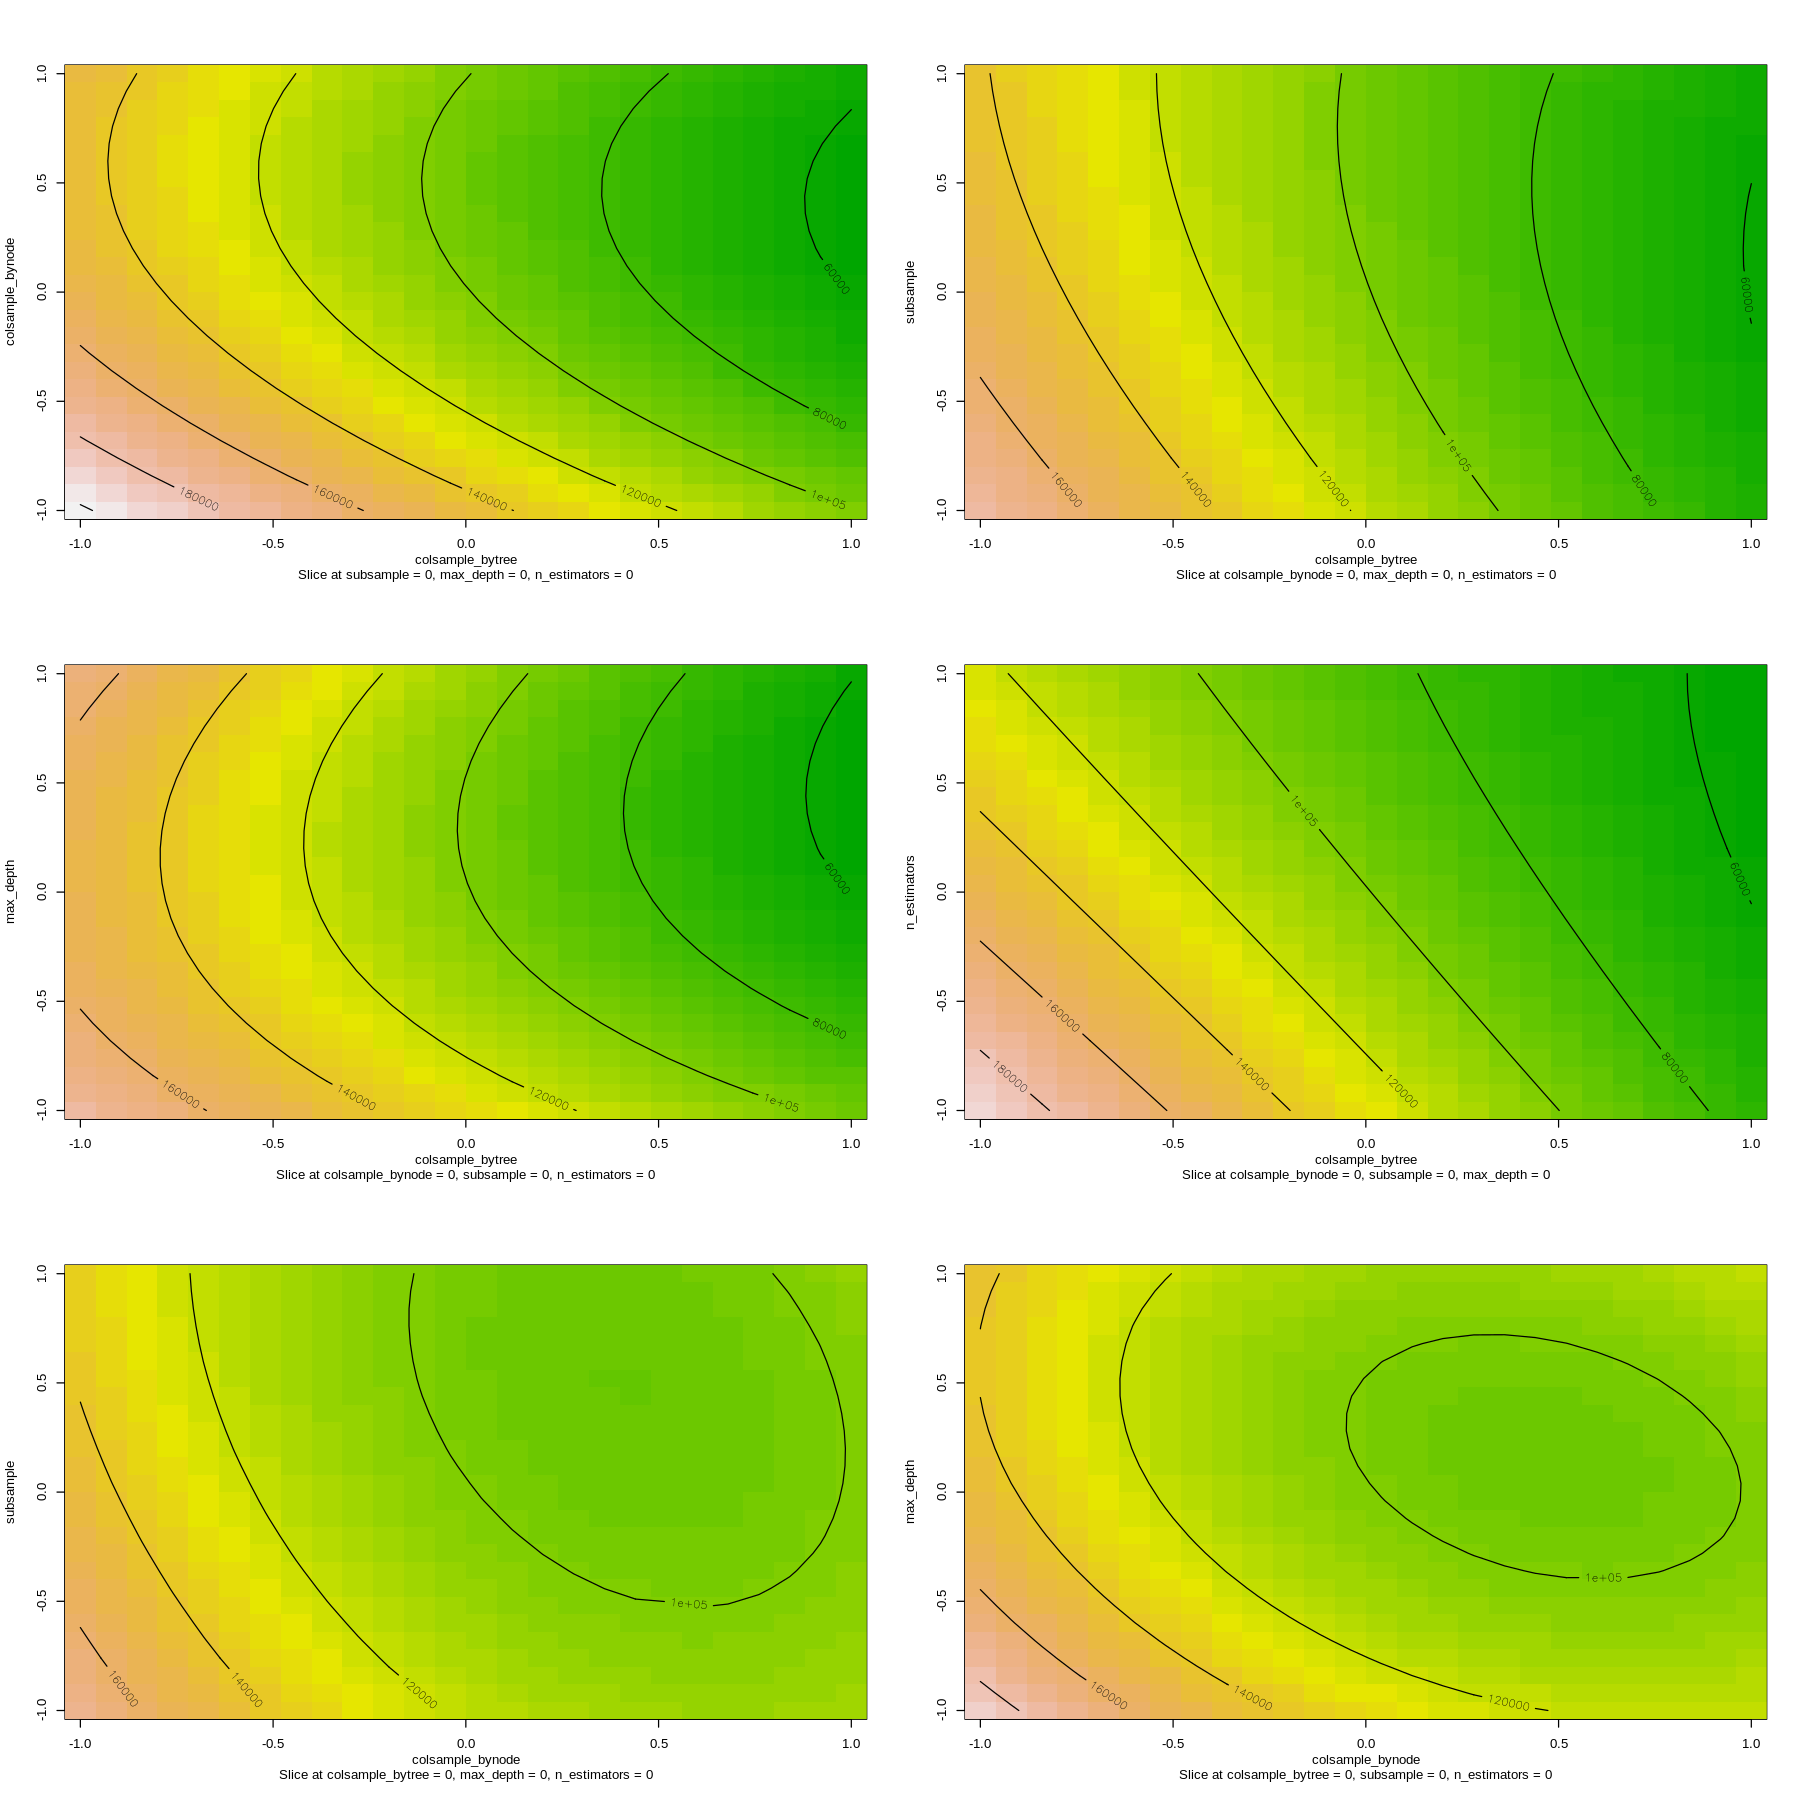

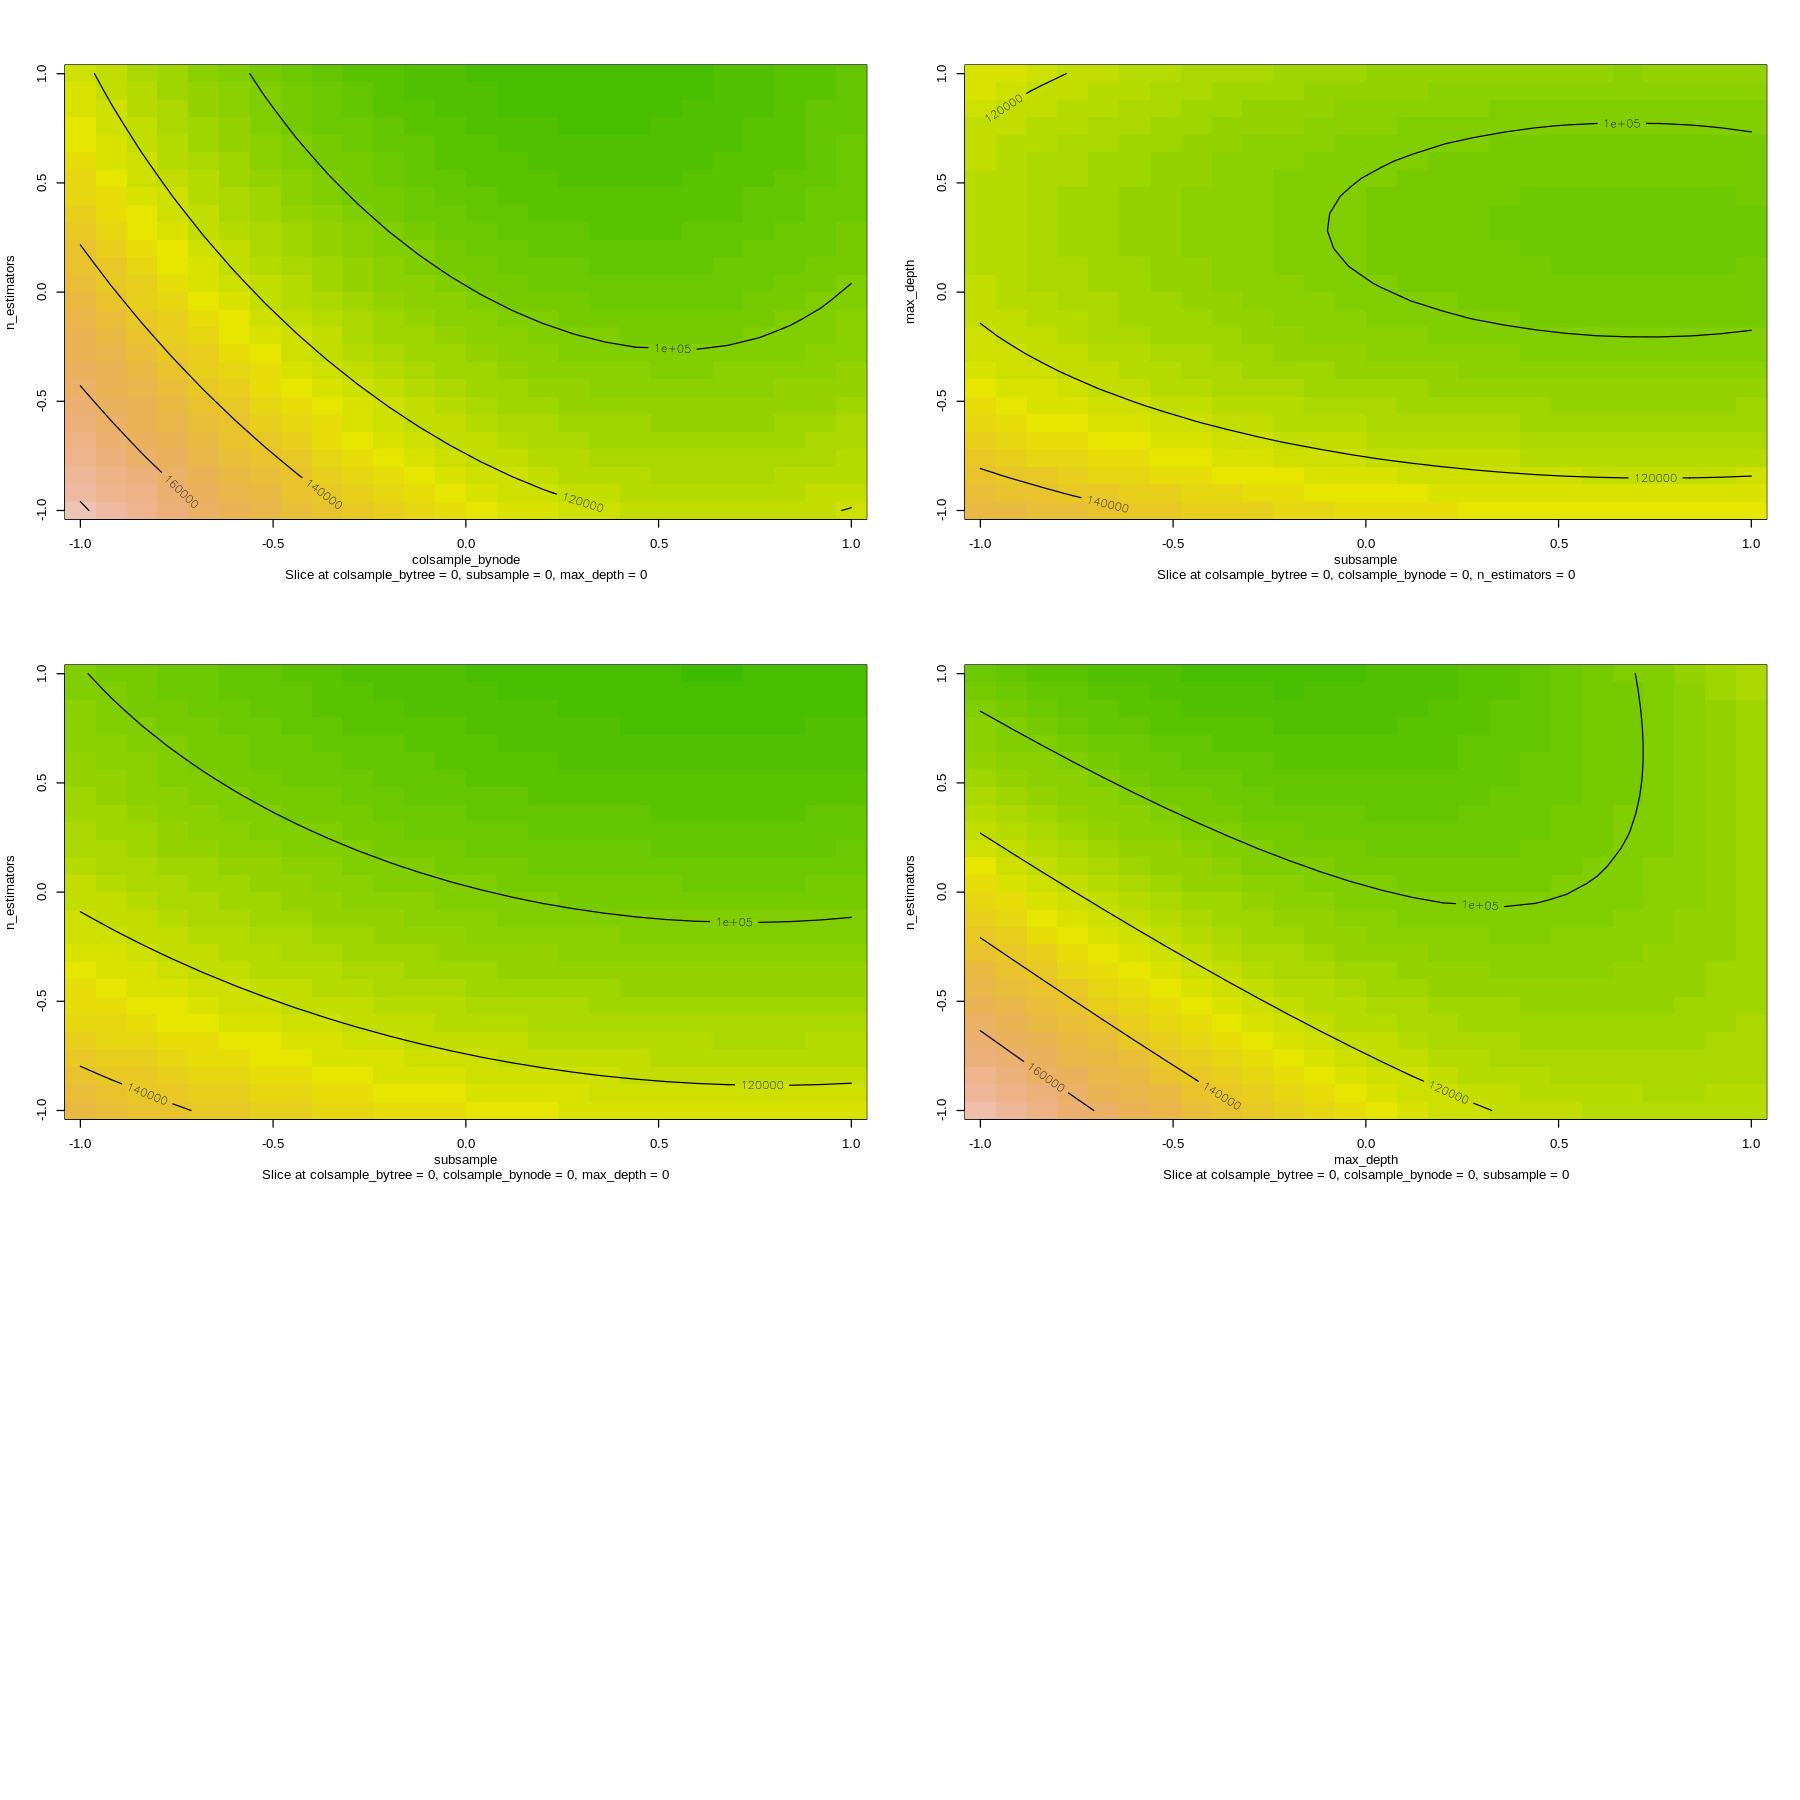

In [ ]:
# FOR BETTER DETAILS OPEN IMAGE IN NEW TAB
options(repr.plot.width = 15, repr.plot.height = 15)
par(mfrow = c(3,2))
contour(
  quad_model,            # Our model
  ~ colsample_bytree+ colsample_bynode+ subsample+ max_depth + n_estimators,    # A formula to obtain the 6 possible graphs
  image = TRUE,           # If image = TRUE, apply color to each contour
  )

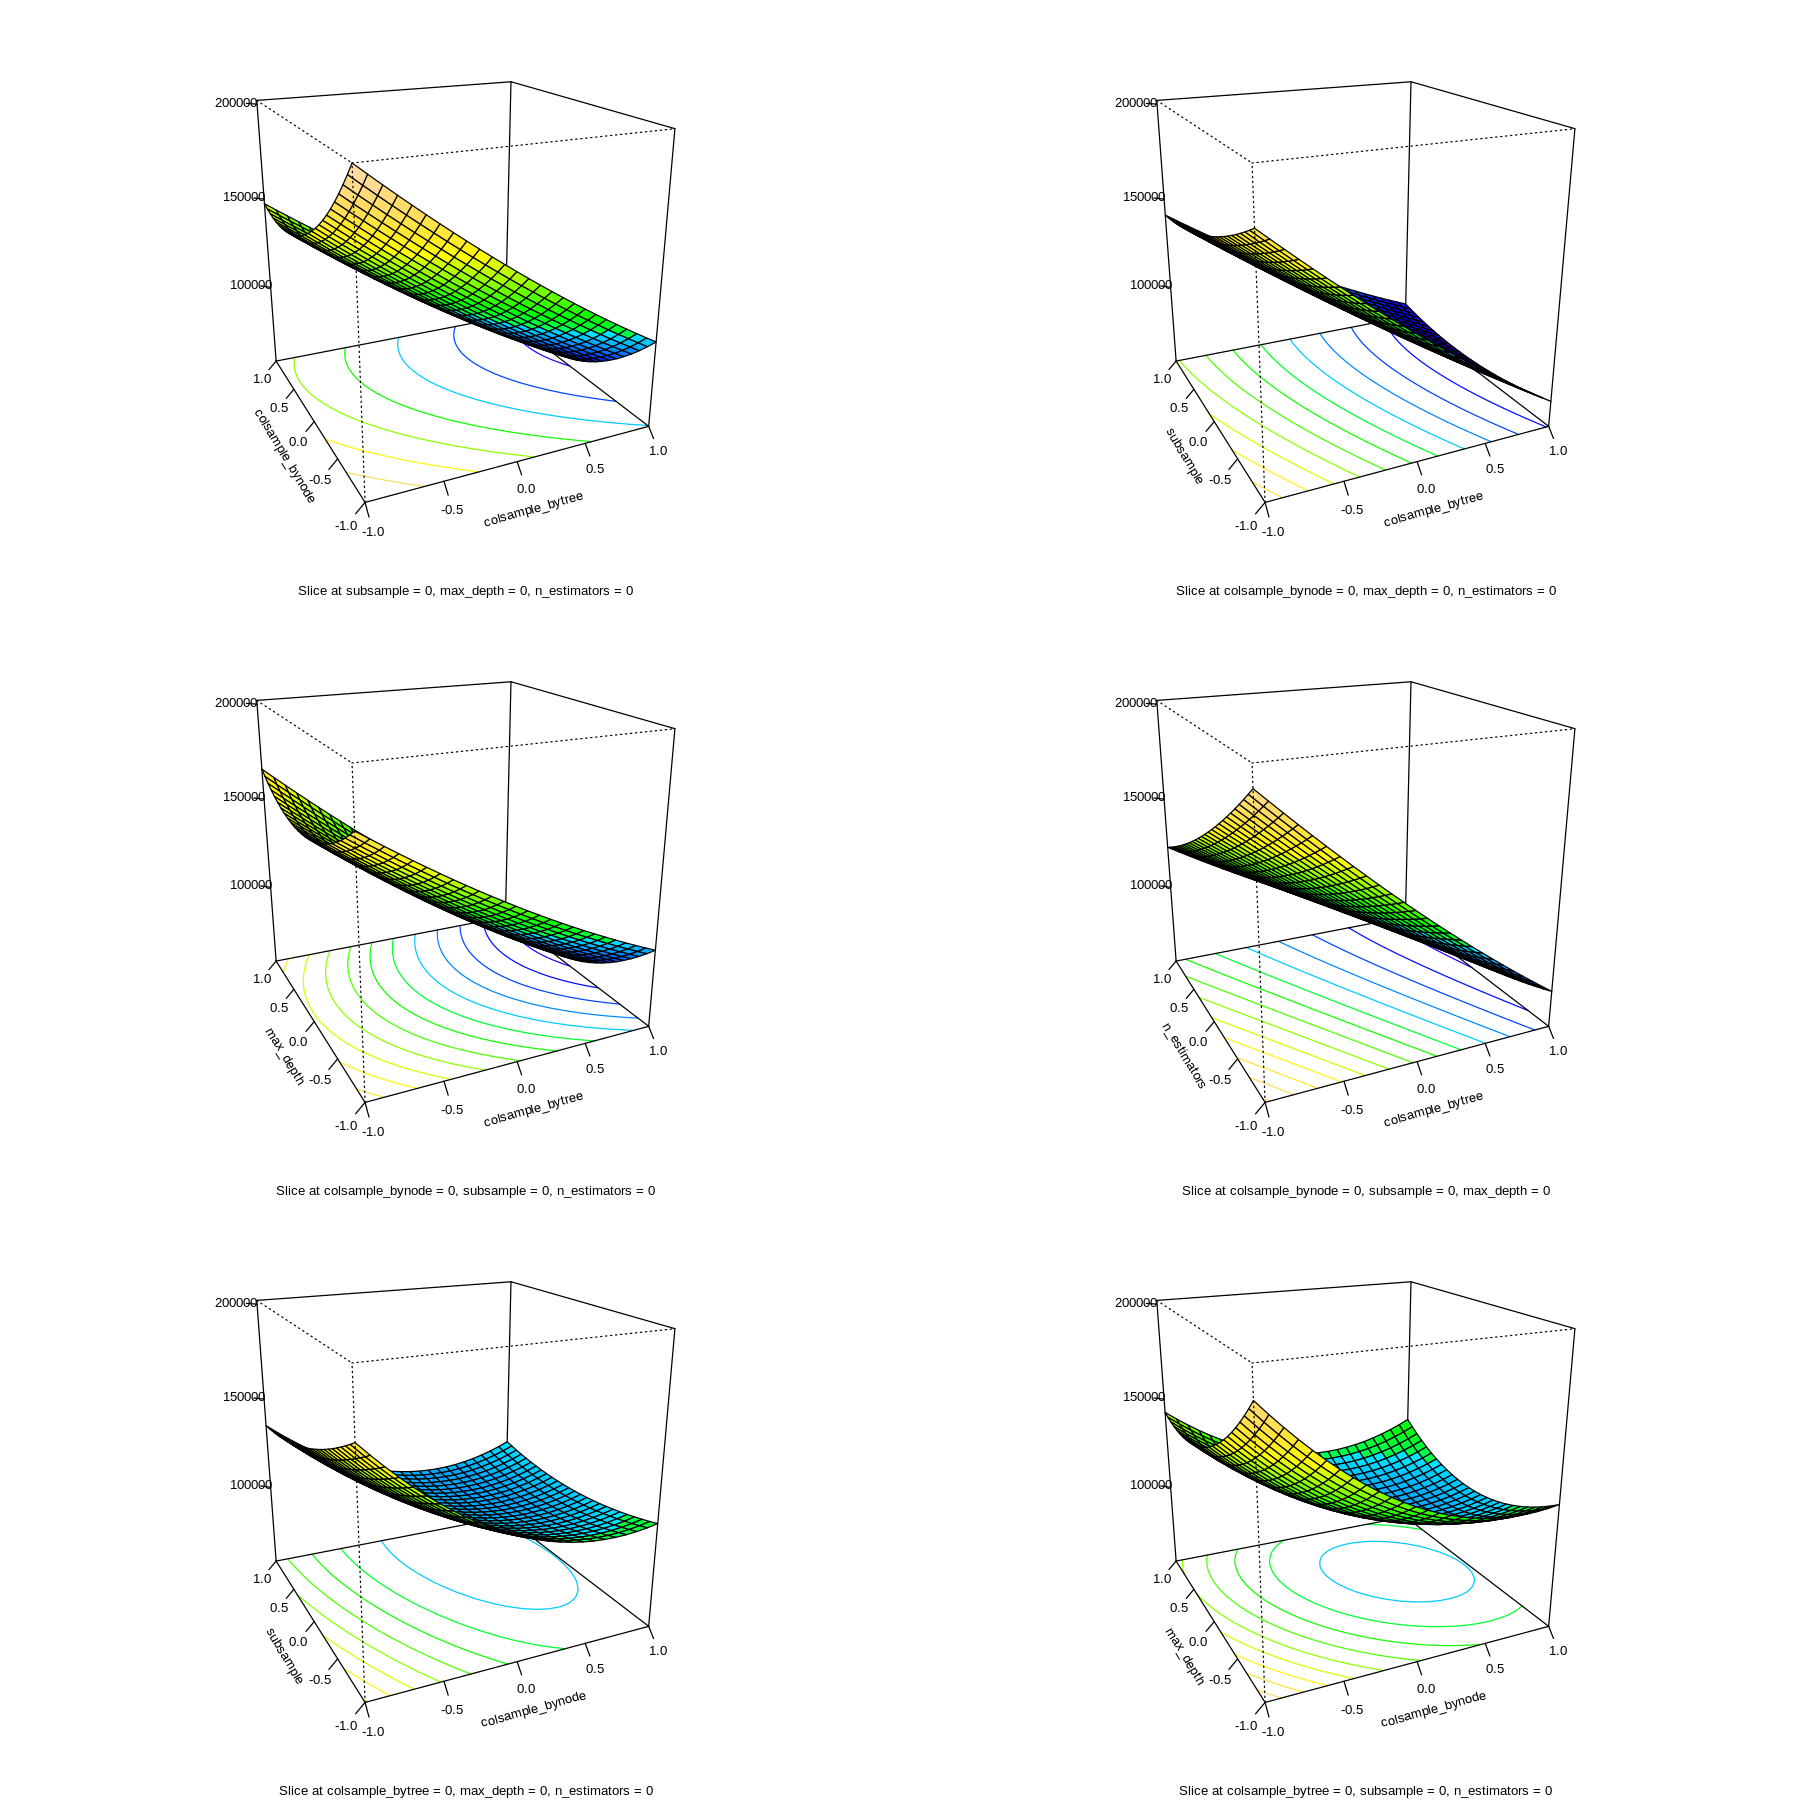

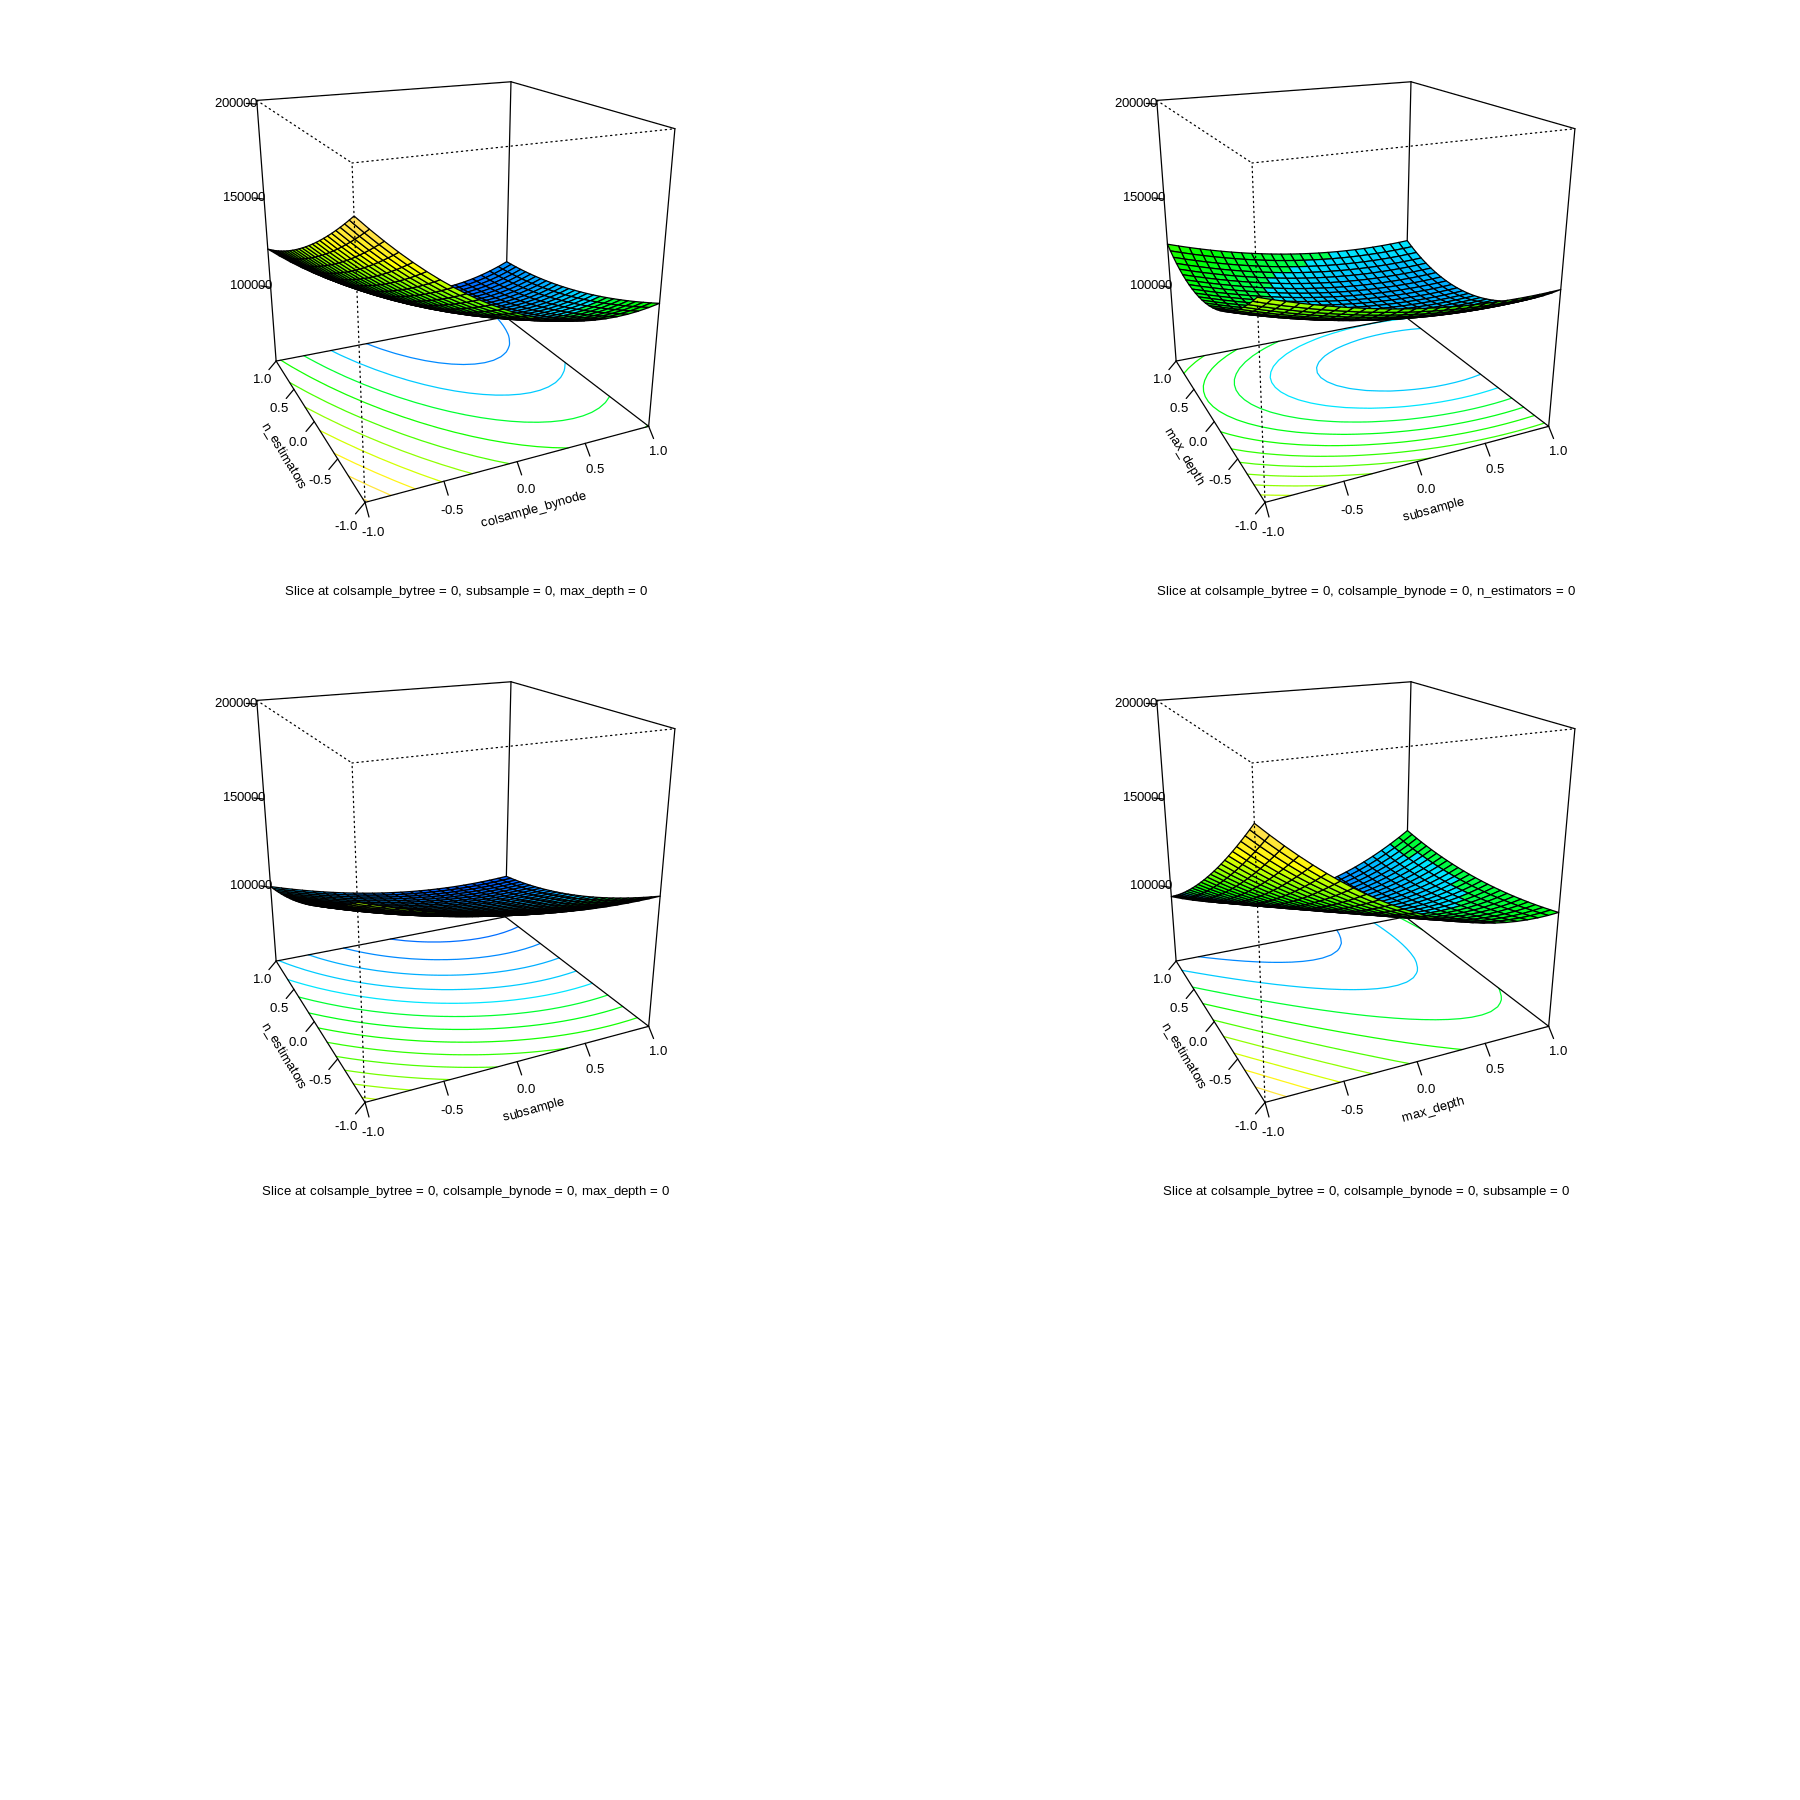

In [ ]:
# FOR BETTER DETAILS OPEN IMAGE IN NEW TAB
options(repr.plot.width = 15, repr.plot.height = 15)
par(mfrow = c(3,2))
persp(
  quad_model,
  ~ colsample_bytree+ colsample_bynode+ subsample+ max_depth + n_estimators,
  col = topo.colors(100), # Color palette
  contours = "colors"     # Include contours with the same color palette
  )

Na základe vizualizácie nášho modelu v oblasti záujmu sme lokalizovali potenciálne optimálne body (uvedené nižše), podľa ktorých sme následne vyskúšali nafitovať XGBoost pričom najlepší výsledok sme získali voči prvému nastaveniu a síce MAE s hodnotou 89123.

In [ ]:
potential_points <- data.frame(colsample_bytree=rep(1, times=7),
                              colsample_bynode=c(0.5, rep(0, times=5), 1),
                             subsample=rep(1, times=7),
                              max_depth=c(0, 0, 0.5, 0, 1, 0, 0),
                               n_estimators=c(rep(0, times=5), 1, 0))


potential_points <- potential_points %>% transmute(
                                        colsample_bytree=0.25*colsample_bytree+0.75,
                                        colsample_bynode=0.25*colsample_bynode+0.75,
                                        subsample=0.25*subsample+0.75,
                                        max_depth=6*max_depth +9,
                                        n_estimators=300*n_estimators +400

)

potential_points

colsample_bytree,colsample_bynode,subsample,max_depth,n_estimators
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.875,1,9,400
1,0.750,1,9,400
1,0.750,1,12,400
1,0.750,1,9,400
1,0.750,1,15,400
1,0.750,1,9,700
1,1.000,1,9,400


In [ ]:
# added learning rate (common sense says it must depends on lr as well)
# --> https://i.imgflip.com/1jllo6.jpg
better_model <- rsm(test_mae ~ SO(colsample_bytree, colsample_bynode, subsample, max_depth,
                               n_estimators,learning_rate) + colsample_bytree:max_depth:subsample
                               +
                                colsample_bytree:max_depth:n_estimators
                               , data = measured_design)

summary(better_model)


Call:
rsm(formula = test_mae ~ SO(colsample_bytree, colsample_bynode, 
    subsample, max_depth, n_estimators, learning_rate) + colsample_bytree:max_depth:subsample + 
    colsample_bytree:max_depth:n_estimators, data = measured_design)

                                        Estimate Std. Error  t value  Pr(>|t|)
(Intercept)                             100459.6     4838.5  20.7627 < 2.2e-16
colsample_bytree                        -46225.9     2476.5 -18.6659 < 2.2e-16
colsample_bynode                        -22804.3     2476.5  -9.2083 9.832e-13
subsample                               -10166.3     2476.5  -4.1051 0.0001350
max_depth                               -11307.4     2476.5  -4.5659 2.842e-05
n_estimators                            -21897.6     2476.5  -8.8422 3.782e-12
learning_rate                             1550.4     2476.5   0.6261 0.5338633
colsample_bytree:colsample_bynode         4402.6     2514.9   1.7506 0.0855917
colsample_bytree:subsample                7654.0  

In [ ]:
x_stat_natur = c((0.25*1.3907035+0.75), (0.25*0.1164915 +0.75), (0.25*(-0.6185296) +0.75),
                  (6*(-0.9353081) +9), (300*2.8693195 +400), 0.030005*(-0.9606229)+0.119995 )


data.frame(colsample_bytree=x_stat_natur[1],colsample_bynode=x_stat_natur[2],
                             subsample=x_stat_natur[3], max_depth=x_stat_natur[4],
                              n_estimators=x_stat_natur[5], learning_rate=x_stat_natur[6])

colsample_bytree,colsample_bynode,subsample,max_depth,n_estimators,learning_rate
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1.097676,0.7791229,0.5953676,3.388151,1260.796,0.09117151


Nakoľko si myslíme, že výsledná hodnota metriky musí byť do istej miery ovplyvnená aj parametrom `learning_rate`
tak sme ho pridali do modelu. Pričom sme získali nový odhad stacionárneho bodu, ktorý je uvedený vyššie. Po evaluácii tohto nastavenia na XGBooste sme dospeli k hodnote MAE 88499.

# Randomized search

Na porovanie výsledkov získaných pomocou 2^(8-2) dizajnu
sme vykonali aj randomized search hyperparametrov, ktorý patrí medzi zaužívané (nesofistikované) metódy optimalizácie hyperparametrov napr. XGBoostu.

Nadefinovaná oblasť parametrického priestoru obsahovala celkovo 315K (8 rozmerných) bodov a preto sme sa rozhodli vynechať brute-force search ale aplikovať len randomizovaný search s 25K iteráciami.

Výsledné optimálne nastavenie je uvedené nižšie.


In [ ]:
xgb_best_result_25k <- data <- read.table("https://raw.githubusercontent.com/Many98/xgboost_hyper_search/main/xgboost_random_search_best.csv",header=TRUE,sep=",")
xgb_best_result_25k

model__subsample,model__n_estimators,model__max_leaves,model__max_depth,model__learning_rate,model__gamma,model__colsample_bytree,model__colsample_bynode,mae
<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
0.5,600,100,6,0.08999,0.5,1,0.95,67747.09


Celkovo vidíme, že v optimálnom nastavení v danej oblasti nadobúda väčšina hyperparametrov "okrajové" hodnoty t.j. minimum MAE je na okraji oblasti čo vyplynulo aj z našej analýzy pomocou response surface dizajnu.

# Záver

V protokole sme si kládli za cieľ optimalizovať hodnoty hyperparametrov algoritmu XGBoost a to takým spôsobom aby sme získali čo na najnižšiu hodnotu testovacej metriky MAE.
Na návrh experimentu sme zvolili 2^(8-2) dizajn a teda bolo nameraných celkovo 64 pozorovaní. Kvôli dodatočným požiadavkam modelu sme vykonali 5 replikovaných meraní v centrálnom bode ako aj 16 nereplikovaných meraní pomocou central composite dizajnu.

Kvalitatívnou a kvantitatívnou analýzou sme zistili, že MAE významne záviselo na faktoroch`colsample_bytree`, `colsample_bynode`, `subsample`, `max_depth`, `n_estimators` a taktiež ich interakciách. Pomocou meraní v centrálnych bodoch sme zistili, že závisloť je dokonca kvadratickou vo faktoroch `colsample_bynode` a `max_depth`.

 Kvadratický model sa nakoniec ukázal byť adekvátnou ale nie postačujúcou aproximáciou skutočného procesu pričom s jeho pomocou sme dokázali odhaliť akési optimálne nastavenie hyperparametrov pomocou ktorého sme dospeli k MAE rovnej 88 499. Na druhú stranu pomocou randomized search prístupu bolo objavené omnoho lepšie nastavenie hyperparametrov, ktoré dávalo hodnotu MAE rovnú 67 747. Toto ale zodpovedá očakávaniam, že závislosť MAE metriky na hyperparametroch algoritmu XGBoost bude prinajmenšom zložitá a teda použitie kvadratickej nadplochy na jej aproximáciu neprinesie významné úspechy.

Použitie factorial dizajnu na hľadanie hyperparametrov algoritmu XGBoost by sme teda odporučili len v prípade extrémne obmedzených zdrojov predovšetkým čo sa týka výpočetného výkonu.